# Notes

## Introduction

### History

2018 was a breakthrough year in NLP. Transfer learning, particularly models like Allen AI's ELMO, OpenAI's Open-GPT, and Google's BERT allowed researchers to smash multiple benchmarks with minimal task-specific fine-tuning and provided the rest of the NLP community with pretrained models that could easily (with less data and less compute time) be fine-tuned and implemented to produce state of the art results. Unfortunately, for many starting out in NLP and even for some experienced practicioners, the theory and practical application of these powerful models is still not well understood.

### What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.

### What Can BERT Do For Me?

This post will explain how you can modify and fine-tune BERT to create a powerful NLP model that quickly gives you state of the art results. 

### Why Fine-Tuning Rather Than Building My Own Model ?

In this tutorial, we will use BERT to train a text classifier. Specifically, we will take the pre-trained BERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need? 

#### Easy Training

First, the pre-trained BERT model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning BERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original BERT model or a LSTM from scratch!). 

#### Less Data

In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning BERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

#### Good Results

Second, this simple fine-tuning procedure (typically adding one fully-connected layer on top of BERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning BERT is shown to be a better (or at least equal) alternative.

#### A Shift in NLP

This shift to transfer learning parallels the same shift that took place in computer vision a few years ago. Creating a good deep learning network for computer vision tasks can take millions of parameters and be very expensive to train. Researchers discovered that deep networks learn hierarchical feature representations (simple features like edges at the lowest layers with gradually more complex features at higher layers). Rather than training a new network from scratch each time, the lower layers of a trained network with generalized image features could be copied and transfered for use in another network with a different task. It soon became common practice to download a pre-trained deep network and quickly retrain it for the new task or add additional layers on top - vastly preferable to the expensive process of training a network from scratch. For many, the introduction of deep pre-trained language models in 2018 (ELMO, BERT, ULMFIT, Open-GPT, etc.) signals the same shift to transfer learning in NLP that computer vision saw.

Let's get started!

## Install and Import

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit -> Notebook Settings -> Add accelerator (GPU)

Then run the following cell to confirm that the GPU is detected.

In [1]:
from datetime import datetime
print(datetime.today())

2020-06-04 22:28:49.336275


In [2]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Next, let's install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

At the moment, the Hugging Face library seems to be the most widely accepted and powerful pytorch interface for working with BERT. In addition to supporting a variety of different pre-trained language models (and future models to come - BERT will not be state of the art forever), the library also includes pre-built modifications of BERT suited to your specific task. For example, in this tutorial we will use BertForSequenceClassification, but the library also includes BERT modifications designed for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.

**Note**: as of July 2019, the pytorch library called "pytorch-pretrained-bert pytorch-nlp" has been updated and renamed as "pytorch-transformers." Though the old name still works, there is a short summary [here](https://github.com/huggingface/pytorch-transformers#Migrating-from-pytorch-pretrained-bert-to-pytorch-transformers) about migrating to the new library. (This mostly involves a few name changes.)

In [3]:
#!pip install pytorch-pretrained-bert pytorch-nlp

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)


'GeForce RTX 2080 Ti'

## Load Dataset


We'll use The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification. It's a set of sentences labeled as grammatically correct or incorrect. The data is as follows:

**Column 1**:	the code representing the source of the sentence.

**Column 2**:	the acceptability judgment label (0=unacceptable, 1=acceptable).

**Column 3**:	the acceptability judgment as originally notated by the author.

**Column 4**:	the sentence.

Download the dataset from this link, extract, and move them to your local drive.

https://nyu-mll.github.io/CoLA/

Both tokenized and raw versions of the data are available. We will use the **raw** version because we need to use the BERT tokenizer to break the text down into tokens and chunks that the model will recognize.

In [6]:
# Upload the train file from your local drive
# from google.colab import files
# uploaded = files.upload()
# uploaded = files.upload()
# uploaded = files.upload()

In [7]:
# uploaded = files.upload()
# uploaded = files.upload()
# uploaded = files.upload()

In [8]:
# uploaded = files.upload()

In [9]:
df1 = pd.read_csv("combined-train.csv", delimiter=',', header=0)
str(df1.message.values)
df2 = pd.read_csv("right_ads_final.csv", delimiter=',', header=0)
str(df2.message.values)
df3 = pd.read_csv("left_ads_final.csv", delimiter=',', header=0)
str(df3.message.values)
df4 = pd.read_csv("neutral_ads.csv", delimiter=',', header=0)
str(df4.message.values)
#****df5 = pd.read_csv("right_ads_2.csv", delimiter=',', header=0)
#****str(df5.message.values)
#****df = pd.concat([df1,df2,df3,df4,df5])
df = pd.concat([df1,df2,df3,df4])

In [10]:
del df1
del df2
del df3
del df4
torch.cuda.empty_cache()



In [11]:
df.shape

(27078, 5)

In [12]:
df.sample(10)

,id,message,advertiser,page,leaning
8355,129812778455609,If the Democrats flip just 4 Senate seats they...,Mitch McConnell,2.59131e+14,right
8427,177439780372757,Message from Mitch:\nOur GOP Senate Majority i...,Mitch McConnell,2.59131e+14,right
618,6.92786e+14,Nate Silver’s FiveThirtyEight says Bernie and ...,Joe Biden,7.86088e+09,left
385,23842891060670787,There’s only one way to get the media out of b...,The Young Turks,https://www.facebook.com/TheYoungTurks/,neutral
11284,8.32853e+14,📢📢📢I have a message for anyone who accuses us ...,Alexandria Ocasio-Cortez,1.31637e+15,left
156,2708984159387925,Have you signed yet?\n\nNothing could make the...,Team Trump,1.77116e+15,right
510,330313721279788,Nothing could make the President’s birthday be...,Team Trump,1.77116e+15,right
3163,1088954501480803,President Trump recognizes how much support yo...,Donald J. Trump,1.53081e+11,right
6967,468971890353031,"""Now, this has been a longstanding meme on the...",The Ben Shapiro Show,1.66354e+15,right
11240,5.88112e+14,"Last week, I joined Bernie in LA for a rally. ...",Alexandria Ocasio-Cortez,1.31637e+15,left


In [13]:
# Create sentence and label lists
sentences = df.message
print(len(sentences))
#for sentence in sentences:
    #if (strlen(sentence > 512)):
        
    

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df.leaning.values
for i in range(len(labels)):
    if labels[i] == 'right':
        labels[i] = 0
    if labels[i] == 'left':
        labels[i] = 1
    if labels[i] == 'neutral':
        labels[i] = 2

labels = np.array(labels,dtype=np.int64)
print(labels.dtype)

print(len(sentences))
  

27078
int64
27078


## Inputs

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


In [15]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'their', 'party', 'has', 'spent', 'the', 'last', 'four', 'years', 're', '##lit', '##iga', '##ting', 'a', 'loss', 'in', '2016', '.', '[SEP]']


BERT requires specifically formatted inputs. For each tokenized input sentence, we need to create:

- **input ids**: a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
- **segment mask**: (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
- **attention mask**: (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
- **labels**: a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

Although we can have variable length input sentences, BERT does requires our input arrays to be the same size. We address this by first choosing a maximum sentence length, and then padding and truncating our inputs until every input sequence is of the same length. 

To "pad" our inputs in this context means that if a sentence is shorter than the maximum sentence length, we simply add 0s to the end of the sequence until it is the maximum sentence length. 

If a sentence is longer than the maximum sentence length, then we simply truncate the end of the sequence, discarding anything that does not fit into our maximum sentence length.

We pad and truncate our sequences so that they all become of length MAX_LEN ("post" indicates that we want to pad and truncate at the end of the sequence, as opposed to the beginning) `pad_sequences` is a utility function that we're borrowing from Keras. It simply handles the truncating and padding of Python lists.

In [16]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 512
print(len(tokenized_texts))

27078


In [17]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (792 > 512). Running this sequence through BERT will result in indexing errors


In [18]:
#np.max([len(seq) for seq in tokenized_texts])
tokenized_texts[0]

['[CLS]',
 'their',
 'party',
 'has',
 'spent',
 'the',
 'last',
 'four',
 'years',
 're',
 '##lit',
 '##iga',
 '##ting',
 'a',
 'loss',
 'in',
 '2016',
 '.',
 '[SEP]']

In [19]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Create the attention masks 

In [20]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [21]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [22]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [23]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
#*****batch_size = 16
batch_size = 4 # Conserve GPU memory

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)




## Train Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

We'll load [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 

### Structure of Fine-Tuning Model

As we've showed beforehand, the first token of every sequence is the special classification token ([CLS]). Unlike the hidden state vector corresponding to a normal word token, the hidden state corresponding to this special token is designated by the authors of BERT as an aggregate representation of the whole sentence used for classification tasks. As such, when we feed in an input sentence to our model during training, the output is the length 768 hidden state vector corresponding to this token. The additional layer that we've added on top consists of untrained linear neurons of size [hidden_state, number_of_labels], so [768,2], meaning that the output of BERT plus our classification layer is a vector of two numbers representing the "score" for "grammatical/non-grammatical" that are then fed into cross-entropy loss.



### The Fine-Tuning Process

Because the pre-trained BERT layers already encode a lot of information about the language, training the classifier is relatively inexpensive. Rather than training every layer in a large model from scratch, it's as if we have already trained the bottom layers 95% of where they need to be, and only really need to train the top layer, with a bit of tweaking going on in the lower levels to accomodate our task.

Sometimes practicioners will opt to "freeze" certain layers when fine-tuning, or to apply different learning rates, apply diminishing learning rates, etc. all in an effort to preserve the good quality weights in the network and speed up training (often considerably). In fact, recent research on BERT specifically has demonstrated that freezing the majority of the weights results in only minimal accuracy declines, but there are exceptions and broader rules of transfer learning that should also be considered. For example, if your task and fine-tuning dataset is very different from the dataset used to train the transfer learning model, freezing the weights may not be a good idea. We'll cover the broader scope of transfer learning in NLP in a future post.  



OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

In [24]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
volatile = True
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
# for name, param in model.named_parameters():
#     if 'classifier' not in name: # classifier layer
#         param.requires_grad = False

model.cuda()




BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend the following hyperparameter ranges:
- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [25]:

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [26]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

t_total value of -1 results in schedule not being applied


Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

In [27]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [28]:

#volatile=True
# This cell causes GPU memory overflow.

t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  # Training
  # Set our model to training mode (as opposed to evaluation mode)
    model.train()
  # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0,0
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()

    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        del batch
        torch.cuda.empty_cache()

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

  # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
    
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
        del batch
        torch.cuda.empty_cache()

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Train loss: 0.09847901712619435


Epoch:  25%|██▌       | 1/4 [38:14<1:54:43, 2294.61s/it]

Validation Accuracy: 0.9855982274741507
Train loss: 0.04275876061827918


Epoch:  50%|█████     | 2/4 [1:16:12<1:16:19, 2289.63s/it]

Validation Accuracy: 0.9848596750369276
Train loss: 0.029902483251183644


Epoch:  75%|███████▌  | 3/4 [1:54:15<38:07, 2287.74s/it]  

Validation Accuracy: 0.9855982274741507
Train loss: 0.022868139780880526


Epoch: 100%|██████████| 4/4 [2:32:22<00:00, 2285.56s/it]

Validation Accuracy: 0.983751846381093


## Training Evaluation

Let's take a look at our training loss over all batches:

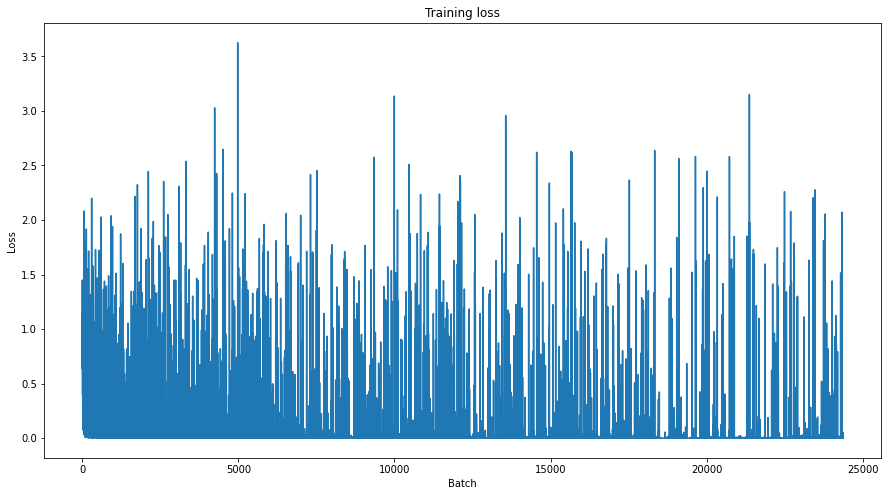

In [29]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [31]:
import pickle
filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))
torch.save(model, open(filename, 'wb'))


In [ ]:
#Use cells below to test

In [10]:
filename = 'finalized_modelJun4_2020.sav'
loaded_model = torch.load(open(filename, 'rb'))

In [ ]:
# Upload the test file from your local drive
#from google.colab import files
#uploaded = files.upload()


In [11]:
#****df = pd.read_csv("propubtest_ads (1).csv", delimiter=',', header=0)
df = pd.read_csv("final_test.csv", delimiter=',', header=0)

# Create sentence and label lists
sentences = df.message.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.leaning.values
for i in range(len(labels)):
    if labels[i] == 'right':
        labels[i] = 0
    if labels[i] == 'left':
        labels[i] = 1
    if labels[i] == 'neutral':
        labels[i] = 2
    
labels = np.array(labels,dtype=np.int64)
print(labels.dtype)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 512

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
#*****batch_size = 32 
batch_size = 4

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (584 > 512). Running this sequence through BERT will result in indexing errors


int64


In [12]:
# Prediction on test set

# Put model in evaluation mode
loaded_model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
    # Forward pass, calculate logit predictions
        logits = loaded_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

In [13]:

# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
# matthews_set = []

# for i in range(len(true_labels)):
#      matthews = matthews_corrcoef(true_labels[i],
#                   np.argmax(predictions[i], axis=1).flatten())
#      matthews_set.append(matthews)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.


In [14]:
#matthews_set

In [15]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print(flat_predictions)
print(flat_true_labels)


[1 1 0 0 1 1 1 0 1 2 1 0 1 1 0 1 1 0 1 0 2 1 1 1 1 2 0 1 2 0 1 1 2 0 0 0 0
 1 1 1 1 1 0 2 0 1 2 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 2 0 1 2 0 0 0 1 1 2 0 2
 0 1 0 2 1 2 1 2 2 0 0 2 0 2 1 0 1 2 1 2 1 2 2 0 2 2 1 2 2 2 2 2 2 1 1 2 0
 2 0 2 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 1 1 1 2 2 0 2 0 2 0 2 2 2 2 2 2 2
 0 2 2 2 2 2 0 2 2 0 2 0 2 2 0]
[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0]


In [16]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.3648884736301765

Cool! In about half an hour and without doing any hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.) we are able to get a good score. I should also mention we didn't train on the entire training dataset, but set aside a portion of it as our validation set for legibililty of code.

If you look at the leaderboard [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy), you'll see that our score (54) using the small version of BERT actually slightly outperforms the BERT authors' CoLA score (52) with the same model. If you wanted to tune the hyperparameters, use the entire train set, or use the larger BERT model instead you're likely able to push that score up higher into the mid- 60s, which looks like the state of the art as of July 2019!


In [17]:


test_count = 0
unsure_count = 0
count = 0
neutral_count = 0
neutral_test = 0
left_test = 0
left_count = 0
right_test = 0
right_count = 0

for i in range(len(df)):
    y_label = flat_predictions[i]
    category = flat_true_labels[i]
    count += 1
    if (category == 2):
        neutral_count += 1
    if (category == 1):
        left_count += 1
    if (category == 0):
        right_count += 1
    if (y_label == category):
        test_count += 1
        if (category == 2):
            neutral_count += 1
        if (category == 0):
            right_test += 1
        if (category == 1):
            left_test += 1
        print("CORRECT!")
        print(df['message'][i], y_label)
        print("is : ", category)
    else:
        print("WRONG!")
        print(df['message'][i], y_label)
        print("is actually: ", category)
        print(test_count, "+", unsure_count, "out of", count)
print("neutral: ", neutral_test, "/", neutral_count)
print("left: ", left_test, "/", left_count)
print("right: ", right_test, "/", right_count)
print(test_count, "+", unsure_count, "out of", count)


CORRECT!
Maine has one of the most active land trust communities in the nation, with more land trusts per capita than any other state. Collectively, Maine’s 75+ land conservation organizations have conserved a little more than 2.5 million acres of the state. Learn more here about how land trusts work for Maine &gt;&gt; http://bit.ly/LandTrustsWorkForMaine 1
is :  1
CORRECT!
URGENT: Trump is directly attacking women's access to birth control coverage. Want to fight back? Donate today. 1
is :  1
WRONG!
Brittany Andrew-Amofah, the Institute’s Senior Policy and Research Analyst, reviews Ontario’s 2018 Economic Outlook and Fall Fiscal Update: “As a result, Ontario’s political/economic reality reflects an ideology rooted in a merciless, autocratic brand of conservative populism that surpasses even the minimal efforts of Mike Harris’ adherence to basic democratic norms, respect for the judiciary, and just plain, fiscal common sense.” 0
is actually:  1
2 + 0 out of 3
WRONG!
First they marched.

In [18]:
from sklearn.metrics import accuracy_score

print(accuracy_score(flat_true_labels, flat_predictions))


0.5828220858895705


In [42]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

# Format confusion matrix:
    
#             right   left    neutral
#     right
#     left
#     neutral

results = confusion_matrix(flat_true_labels, flat_predictions) 
  
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(flat_true_labels, flat_predictions))
print('Report : ')
print(classification_report(flat_true_labels, flat_predictions))

Confusion Matrix :
[[ 7  2  2]
 [22 37 11]
 [19 13 50]]
Accuracy Score : 0.5766871165644172
Report : 
              precision    recall  f1-score   support

           0       0.15      0.64      0.24        11
           1       0.71      0.53      0.61        70
           2       0.79      0.61      0.69        82

    accuracy                           0.58       163
   macro avg       0.55      0.59      0.51       163
weighted avg       0.71      0.58      0.62       163



In [ ]:
# Accuracies by class:
#   right   = 7+22+19 = 48  accuracy: 7/48  = 15%
#   left    = 2+37+13 = 52  accuracy: 37/52 = 71%
#   neutral = 1+11+50 = 62  accuracy: 50/62 = 81%


In [41]:
from datetime import datetime
print(datetime.today())

2020-06-04 16:23:30.544594


## Conclusion

This post demonstrate that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

In [43]:
!nvidia-smi --query --display=MEMORY


==============NVSMI LOG==============

Timestamp                           : Thu Jun  4 16:56:34 2020
Driver Version                      : 440.64
CUDA Version                        : 10.2

Attached GPUs                       : 1
GPU 00000000:73:00.0
    FB Memory Usage
        Total                       : 11016 MiB
        Used                        : 3220 MiB
        Free                        : 7796 MiB
    BAR1 Memory Usage
        Total                       : 256 MiB
        Used                        : 9 MiB
        Free                        : 247 MiB



FINAL TEST

In [19]:
filename = 'finalized_modelJun4_2020.sav'
loaded_model = torch.load(open(filename, 'rb'))

In [23]:
#****df = pd.read_csv("propubtest_ads (1).csv", delimiter=',', header=0)
df = pd.read_csv("APIads_classifier.csv", delimiter=',', header=0)

# Create sentence and label lists
sentences = df.message.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = df.leaning.values
for i in range(len(labels)):
    if labels[i] == 'right':
        labels[i] = 0
    if labels[i] == 'left':
        labels[i] = 1
    if labels[i] == 'neutral':
        labels[i] = 2
    
labels = np.array(labels,dtype=np.int64)
print(labels.dtype)

#tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
tokenized_texts = []
for sent in sentences:
    text = tokenizer.tokenize(sent)
    if len(text) > 512:
        text = text[:512]
    tokenized_texts.append(text)
    



# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
#*****batch_size = 32 
batch_size = 4

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

int64


In [ ]:
# Prediction on test set

# Put model in evaluation mode
loaded_model.eval()
print("loaded model")

# Tracking variables 
predictions , true_labels = [], []

# Predict 
count = 0
for batch in prediction_dataloader:
    count += 1
    print("batch", count)
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
    # Forward pass, calculate logit predictions
        logits = loaded_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

loaded model
batch 1
batch 2
batch 3
batch 4
batch 5
batch 6
batch 7
batch 8
batch 9
batch 10
batch 11
batch 12
batch 13
batch 14
batch 15
batch 16
batch 17
batch 18
batch 19
batch 20
batch 21
batch 22
batch 23
batch 24
batch 25
batch 26
batch 27
batch 28
batch 29
batch 30
batch 31
batch 32
batch 33
batch 34
batch 35
batch 36
batch 37
batch 38
batch 39
batch 40
batch 41
batch 42
batch 43
batch 44
batch 45
batch 46
batch 47
batch 48
batch 49
batch 50
batch 51
batch 52
batch 53
batch 54
batch 55
batch 56
batch 57
batch 58
batch 59
batch 60
batch 61
batch 62
batch 63
batch 64
batch 65
batch 66
batch 67
batch 68
batch 69
batch 70
batch 71
batch 72
batch 73
batch 74
batch 75
batch 76
batch 77
batch 78
batch 79
batch 80
batch 81
batch 82
batch 83
batch 84
batch 85
batch 86
batch 87
batch 88
batch 89
batch 90
batch 91
batch 92
batch 93
batch 94
batch 95
batch 96
batch 97
batch 98
batch 99
batch 100
batch 101
batch 102
batch 103
batch 104
batch 105
batch 106
batch 107
batch 108
batch 109
batch

batch 832
batch 833
batch 834
batch 835
batch 836
batch 837
batch 838
batch 839
batch 840
batch 841
batch 842
batch 843
batch 844
batch 845
batch 846
batch 847
batch 848
batch 849
batch 850
batch 851
batch 852
batch 853
batch 854
batch 855
batch 856
batch 857
batch 858
batch 859
batch 860
batch 861
batch 862
batch 863
batch 864
batch 865
batch 866
batch 867
batch 868
batch 869
batch 870
batch 871
batch 872
batch 873
batch 874
batch 875
batch 876
batch 877
batch 878
batch 879
batch 880
batch 881
batch 882
batch 883
batch 884
batch 885
batch 886
batch 887
batch 888
batch 889
batch 890
batch 891
batch 892
batch 893
batch 894
batch 895
batch 896
batch 897
batch 898
batch 899
batch 900
batch 901
batch 902
batch 903
batch 904
batch 905
batch 906
batch 907
batch 908
batch 909
batch 910
batch 911
batch 912
batch 913
batch 914
batch 915
batch 916
batch 917
batch 918
batch 919
batch 920
batch 921
batch 922
batch 923
batch 924
batch 925
batch 926
batch 927
batch 928
batch 929
batch 930
batch 931


batch 1596
batch 1597
batch 1598
batch 1599
batch 1600
batch 1601
batch 1602
batch 1603
batch 1604
batch 1605
batch 1606
batch 1607
batch 1608
batch 1609
batch 1610
batch 1611
batch 1612
batch 1613
batch 1614
batch 1615
batch 1616
batch 1617
batch 1618
batch 1619
batch 1620
batch 1621
batch 1622
batch 1623
batch 1624
batch 1625
batch 1626
batch 1627
batch 1628
batch 1629
batch 1630
batch 1631
batch 1632
batch 1633
batch 1634
batch 1635
batch 1636
batch 1637
batch 1638
batch 1639
batch 1640
batch 1641
batch 1642
batch 1643
batch 1644
batch 1645
batch 1646
batch 1647
batch 1648
batch 1649
batch 1650
batch 1651
batch 1652
batch 1653
batch 1654
batch 1655
batch 1656
batch 1657
batch 1658
batch 1659
batch 1660
batch 1661
batch 1662
batch 1663
batch 1664
batch 1665
batch 1666
batch 1667
batch 1668
batch 1669
batch 1670
batch 1671
batch 1672
batch 1673
batch 1674
batch 1675
batch 1676
batch 1677
batch 1678
batch 1679
batch 1680
batch 1681
batch 1682
batch 1683
batch 1684
batch 1685
batch 1686

batch 2344
batch 2345
batch 2346
batch 2347
batch 2348
batch 2349
batch 2350
batch 2351
batch 2352
batch 2353
batch 2354
batch 2355
batch 2356
batch 2357
batch 2358
batch 2359
batch 2360
batch 2361
batch 2362
batch 2363
batch 2364
batch 2365
batch 2366
batch 2367
batch 2368
batch 2369
batch 2370
batch 2371
batch 2372
batch 2373
batch 2374
batch 2375
batch 2376
batch 2377
batch 2378
batch 2379
batch 2380
batch 2381
batch 2382
batch 2383
batch 2384
batch 2385
batch 2386
batch 2387
batch 2388
batch 2389
batch 2390
batch 2391
batch 2392
batch 2393
batch 2394
batch 2395
batch 2396
batch 2397
batch 2398
batch 2399
batch 2400
batch 2401
batch 2402
batch 2403
batch 2404
batch 2405
batch 2406
batch 2407
batch 2408
batch 2409
batch 2410
batch 2411
batch 2412
batch 2413
batch 2414
batch 2415
batch 2416
batch 2417
batch 2418
batch 2419
batch 2420
batch 2421
batch 2422
batch 2423
batch 2424
batch 2425
batch 2426
batch 2427
batch 2428
batch 2429
batch 2430
batch 2431
batch 2432
batch 2433
batch 2434

batch 3092
batch 3093
batch 3094
batch 3095
batch 3096
batch 3097
batch 3098
batch 3099
batch 3100
batch 3101
batch 3102
batch 3103
batch 3104
batch 3105
batch 3106
batch 3107
batch 3108
batch 3109
batch 3110
batch 3111
batch 3112
batch 3113
batch 3114
batch 3115
batch 3116
batch 3117
batch 3118
batch 3119
batch 3120
batch 3121
batch 3122
batch 3123
batch 3124
batch 3125
batch 3126
batch 3127
batch 3128
batch 3129
batch 3130
batch 3131
batch 3132
batch 3133
batch 3134
batch 3135
batch 3136
batch 3137
batch 3138
batch 3139
batch 3140
batch 3141
batch 3142
batch 3143
batch 3144
batch 3145
batch 3146
batch 3147
batch 3148
batch 3149
batch 3150
batch 3151
batch 3152
batch 3153
batch 3154
batch 3155
batch 3156
batch 3157
batch 3158
batch 3159
batch 3160
batch 3161
batch 3162
batch 3163
batch 3164
batch 3165
batch 3166
batch 3167
batch 3168
batch 3169
batch 3170
batch 3171
batch 3172
batch 3173
batch 3174
batch 3175
batch 3176
batch 3177
batch 3178
batch 3179
batch 3180
batch 3181
batch 3182

batch 3840
batch 3841
batch 3842
batch 3843
batch 3844
batch 3845
batch 3846
batch 3847
batch 3848
batch 3849
batch 3850
batch 3851
batch 3852
batch 3853
batch 3854
batch 3855
batch 3856
batch 3857
batch 3858
batch 3859
batch 3860
batch 3861
batch 3862
batch 3863
batch 3864
batch 3865
batch 3866
batch 3867
batch 3868
batch 3869
batch 3870
batch 3871
batch 3872
batch 3873
batch 3874
batch 3875
batch 3876
batch 3877
batch 3878
batch 3879
batch 3880
batch 3881
batch 3882
batch 3883
batch 3884
batch 3885
batch 3886
batch 3887
batch 3888
batch 3889
batch 3890
batch 3891
batch 3892
batch 3893
batch 3894
batch 3895
batch 3896
batch 3897
batch 3898
batch 3899
batch 3900
batch 3901
batch 3902
batch 3903
batch 3904
batch 3905
batch 3906
batch 3907
batch 3908
batch 3909
batch 3910
batch 3911
batch 3912
batch 3913
batch 3914
batch 3915
batch 3916
batch 3917
batch 3918
batch 3919
batch 3920
batch 3921
batch 3922
batch 3923
batch 3924
batch 3925
batch 3926
batch 3927
batch 3928
batch 3929
batch 3930

batch 4588
batch 4589
batch 4590
batch 4591
batch 4592
batch 4593
batch 4594
batch 4595
batch 4596
batch 4597
batch 4598
batch 4599
batch 4600
batch 4601
batch 4602
batch 4603
batch 4604
batch 4605
batch 4606
batch 4607
batch 4608
batch 4609
batch 4610
batch 4611
batch 4612
batch 4613
batch 4614
batch 4615
batch 4616
batch 4617
batch 4618
batch 4619
batch 4620
batch 4621
batch 4622
batch 4623
batch 4624
batch 4625
batch 4626
batch 4627
batch 4628
batch 4629
batch 4630
batch 4631
batch 4632
batch 4633
batch 4634
batch 4635
batch 4636
batch 4637
batch 4638
batch 4639
batch 4640
batch 4641
batch 4642
batch 4643
batch 4644
batch 4645
batch 4646
batch 4647
batch 4648
batch 4649
batch 4650
batch 4651
batch 4652
batch 4653
batch 4654
batch 4655
batch 4656
batch 4657
batch 4658
batch 4659
batch 4660
batch 4661
batch 4662
batch 4663
batch 4664
batch 4665
batch 4666
batch 4667
batch 4668
batch 4669
batch 4670
batch 4671
batch 4672
batch 4673
batch 4674
batch 4675
batch 4676
batch 4677
batch 4678

batch 5336
batch 5337
batch 5338
batch 5339
batch 5340
batch 5341
batch 5342
batch 5343
batch 5344
batch 5345
batch 5346
batch 5347
batch 5348
batch 5349
batch 5350
batch 5351
batch 5352
batch 5353
batch 5354
batch 5355
batch 5356
batch 5357
batch 5358
batch 5359
batch 5360
batch 5361
batch 5362
batch 5363
batch 5364
batch 5365
batch 5366
batch 5367
batch 5368
batch 5369
batch 5370
batch 5371
batch 5372
batch 5373
batch 5374
batch 5375
batch 5376
batch 5377
batch 5378
batch 5379
batch 5380
batch 5381
batch 5382
batch 5383
batch 5384
batch 5385
batch 5386
batch 5387
batch 5388
batch 5389
batch 5390
batch 5391
batch 5392
batch 5393
batch 5394
batch 5395
batch 5396
batch 5397
batch 5398
batch 5399
batch 5400
batch 5401
batch 5402
batch 5403
batch 5404
batch 5405
batch 5406
batch 5407
batch 5408
batch 5409
batch 5410
batch 5411
batch 5412
batch 5413
batch 5414
batch 5415
batch 5416
batch 5417
batch 5418
batch 5419
batch 5420
batch 5421
batch 5422
batch 5423
batch 5424
batch 5425
batch 5426

batch 6084
batch 6085
batch 6086
batch 6087
batch 6088
batch 6089
batch 6090
batch 6091
batch 6092
batch 6093
batch 6094
batch 6095
batch 6096
batch 6097
batch 6098
batch 6099
batch 6100
batch 6101
batch 6102
batch 6103
batch 6104
batch 6105
batch 6106
batch 6107
batch 6108
batch 6109
batch 6110
batch 6111
batch 6112
batch 6113
batch 6114
batch 6115
batch 6116
batch 6117
batch 6118
batch 6119
batch 6120
batch 6121
batch 6122
batch 6123
batch 6124
batch 6125
batch 6126
batch 6127
batch 6128
batch 6129
batch 6130
batch 6131
batch 6132
batch 6133
batch 6134
batch 6135
batch 6136
batch 6137
batch 6138
batch 6139
batch 6140
batch 6141
batch 6142
batch 6143
batch 6144
batch 6145
batch 6146
batch 6147
batch 6148
batch 6149
batch 6150
batch 6151
batch 6152
batch 6153
batch 6154
batch 6155
batch 6156
batch 6157
batch 6158
batch 6159
batch 6160
batch 6161
batch 6162
batch 6163
batch 6164
batch 6165
batch 6166
batch 6167
batch 6168
batch 6169
batch 6170
batch 6171
batch 6172
batch 6173
batch 6174

batch 6832
batch 6833
batch 6834
batch 6835
batch 6836
batch 6837
batch 6838
batch 6839
batch 6840
batch 6841
batch 6842
batch 6843
batch 6844
batch 6845
batch 6846
batch 6847
batch 6848
batch 6849
batch 6850
batch 6851
batch 6852
batch 6853
batch 6854
batch 6855
batch 6856
batch 6857
batch 6858
batch 6859
batch 6860
batch 6861
batch 6862
batch 6863
batch 6864
batch 6865
batch 6866
batch 6867
batch 6868
batch 6869
batch 6870
batch 6871
batch 6872
batch 6873
batch 6874
batch 6875
batch 6876
batch 6877
batch 6878
batch 6879
batch 6880
batch 6881
batch 6882
batch 6883
batch 6884
batch 6885
batch 6886
batch 6887
batch 6888
batch 6889
batch 6890
batch 6891
batch 6892
batch 6893
batch 6894
batch 6895
batch 6896
batch 6897
batch 6898
batch 6899
batch 6900
batch 6901
batch 6902
batch 6903
batch 6904
batch 6905
batch 6906
batch 6907
batch 6908
batch 6909
batch 6910
batch 6911
batch 6912
batch 6913
batch 6914
batch 6915
batch 6916
batch 6917
batch 6918
batch 6919
batch 6920
batch 6921
batch 6922

batch 7580
batch 7581
batch 7582
batch 7583
batch 7584
batch 7585
batch 7586
batch 7587
batch 7588
batch 7589
batch 7590
batch 7591
batch 7592
batch 7593
batch 7594
batch 7595
batch 7596
batch 7597
batch 7598
batch 7599
batch 7600
batch 7601
batch 7602
batch 7603
batch 7604
batch 7605
batch 7606
batch 7607
batch 7608
batch 7609
batch 7610
batch 7611
batch 7612
batch 7613
batch 7614
batch 7615
batch 7616
batch 7617
batch 7618
batch 7619
batch 7620
batch 7621
batch 7622
batch 7623
batch 7624
batch 7625
batch 7626
batch 7627
batch 7628
batch 7629
batch 7630
batch 7631
batch 7632
batch 7633
batch 7634
batch 7635
batch 7636
batch 7637
batch 7638
batch 7639
batch 7640
batch 7641
batch 7642
batch 7643
batch 7644
batch 7645
batch 7646
batch 7647
batch 7648
batch 7649
batch 7650
batch 7651
batch 7652
batch 7653
batch 7654
batch 7655
batch 7656
batch 7657
batch 7658
batch 7659
batch 7660
batch 7661
batch 7662
batch 7663
batch 7664
batch 7665
batch 7666
batch 7667
batch 7668
batch 7669
batch 7670

batch 8328
batch 8329
batch 8330
batch 8331
batch 8332
batch 8333
batch 8334
batch 8335
batch 8336
batch 8337
batch 8338
batch 8339
batch 8340
batch 8341
batch 8342
batch 8343
batch 8344
batch 8345
batch 8346
batch 8347
batch 8348
batch 8349
batch 8350
batch 8351
batch 8352
batch 8353
batch 8354
batch 8355
batch 8356
batch 8357
batch 8358
batch 8359
batch 8360
batch 8361
batch 8362
batch 8363
batch 8364
batch 8365
batch 8366
batch 8367
batch 8368
batch 8369
batch 8370
batch 8371
batch 8372
batch 8373
batch 8374
batch 8375
batch 8376
batch 8377
batch 8378
batch 8379
batch 8380
batch 8381
batch 8382
batch 8383
batch 8384
batch 8385
batch 8386
batch 8387
batch 8388
batch 8389
batch 8390
batch 8391
batch 8392
batch 8393
batch 8394
batch 8395
batch 8396
batch 8397
batch 8398
batch 8399
batch 8400
batch 8401
batch 8402
batch 8403
batch 8404
batch 8405
batch 8406
batch 8407
batch 8408
batch 8409
batch 8410
batch 8411
batch 8412
batch 8413
batch 8414
batch 8415
batch 8416
batch 8417
batch 8418

batch 9076
batch 9077
batch 9078
batch 9079
batch 9080
batch 9081
batch 9082
batch 9083
batch 9084
batch 9085
batch 9086
batch 9087
batch 9088
batch 9089
batch 9090
batch 9091
batch 9092
batch 9093
batch 9094
batch 9095
batch 9096
batch 9097
batch 9098
batch 9099
batch 9100
batch 9101
batch 9102
batch 9103
batch 9104
batch 9105
batch 9106
batch 9107
batch 9108
batch 9109
batch 9110
batch 9111
batch 9112
batch 9113
batch 9114
batch 9115
batch 9116
batch 9117
batch 9118
batch 9119
batch 9120
batch 9121
batch 9122
batch 9123
batch 9124
batch 9125
batch 9126
batch 9127
batch 9128
batch 9129
batch 9130
batch 9131
batch 9132
batch 9133
batch 9134
batch 9135
batch 9136
batch 9137
batch 9138
batch 9139
batch 9140
batch 9141
batch 9142
batch 9143
batch 9144
batch 9145
batch 9146
batch 9147
batch 9148
batch 9149
batch 9150
batch 9151
batch 9152
batch 9153
batch 9154
batch 9155
batch 9156
batch 9157
batch 9158
batch 9159
batch 9160
batch 9161
batch 9162
batch 9163
batch 9164
batch 9165
batch 9166

batch 9824
batch 9825
batch 9826
batch 9827
batch 9828
batch 9829
batch 9830
batch 9831
batch 9832
batch 9833
batch 9834
batch 9835
batch 9836
batch 9837
batch 9838
batch 9839
batch 9840
batch 9841
batch 9842
batch 9843
batch 9844
batch 9845
batch 9846
batch 9847
batch 9848
batch 9849
batch 9850
batch 9851
batch 9852
batch 9853
batch 9854
batch 9855
batch 9856
batch 9857
batch 9858
batch 9859
batch 9860
batch 9861
batch 9862
batch 9863
batch 9864
batch 9865
batch 9866
batch 9867
batch 9868
batch 9869
batch 9870
batch 9871
batch 9872
batch 9873
batch 9874
batch 9875
batch 9876
batch 9877
batch 9878
batch 9879
batch 9880
batch 9881
batch 9882
batch 9883
batch 9884
batch 9885
batch 9886
batch 9887
batch 9888
batch 9889
batch 9890
batch 9891
batch 9892
batch 9893
batch 9894
batch 9895
batch 9896
batch 9897
batch 9898
batch 9899
batch 9900
batch 9901
batch 9902
batch 9903
batch 9904
batch 9905
batch 9906
batch 9907
batch 9908
batch 9909
batch 9910
batch 9911
batch 9912
batch 9913
batch 9914

batch 10524
batch 10525
batch 10526
batch 10527
batch 10528
batch 10529
batch 10530
batch 10531
batch 10532
batch 10533
batch 10534
batch 10535
batch 10536
batch 10537
batch 10538
batch 10539
batch 10540
batch 10541
batch 10542
batch 10543
batch 10544
batch 10545
batch 10546
batch 10547
batch 10548
batch 10549
batch 10550
batch 10551
batch 10552
batch 10553
batch 10554
batch 10555
batch 10556
batch 10557
batch 10558
batch 10559
batch 10560
batch 10561
batch 10562
batch 10563
batch 10564
batch 10565
batch 10566
batch 10567
batch 10568
batch 10569
batch 10570
batch 10571
batch 10572
batch 10573
batch 10574
batch 10575
batch 10576
batch 10577
batch 10578
batch 10579
batch 10580
batch 10581
batch 10582
batch 10583
batch 10584
batch 10585
batch 10586
batch 10587
batch 10588
batch 10589
batch 10590
batch 10591
batch 10592
batch 10593
batch 10594
batch 10595
batch 10596
batch 10597
batch 10598
batch 10599
batch 10600
batch 10601
batch 10602
batch 10603
batch 10604
batch 10605
batch 10606
batc

batch 11208
batch 11209
batch 11210
batch 11211
batch 11212
batch 11213
batch 11214
batch 11215
batch 11216
batch 11217
batch 11218
batch 11219
batch 11220
batch 11221
batch 11222
batch 11223
batch 11224
batch 11225
batch 11226
batch 11227
batch 11228
batch 11229
batch 11230
batch 11231
batch 11232
batch 11233
batch 11234
batch 11235
batch 11236
batch 11237
batch 11238
batch 11239
batch 11240
batch 11241
batch 11242
batch 11243
batch 11244
batch 11245
batch 11246
batch 11247
batch 11248
batch 11249
batch 11250
batch 11251
batch 11252
batch 11253
batch 11254
batch 11255
batch 11256
batch 11257
batch 11258
batch 11259
batch 11260
batch 11261
batch 11262
batch 11263
batch 11264
batch 11265
batch 11266
batch 11267
batch 11268
batch 11269
batch 11270
batch 11271
batch 11272
batch 11273
batch 11274
batch 11275
batch 11276
batch 11277
batch 11278
batch 11279
batch 11280
batch 11281
batch 11282
batch 11283
batch 11284
batch 11285
batch 11286
batch 11287
batch 11288
batch 11289
batch 11290
batc

batch 11892
batch 11893
batch 11894
batch 11895
batch 11896
batch 11897
batch 11898
batch 11899
batch 11900
batch 11901
batch 11902
batch 11903
batch 11904
batch 11905
batch 11906
batch 11907
batch 11908
batch 11909
batch 11910
batch 11911
batch 11912
batch 11913
batch 11914
batch 11915
batch 11916
batch 11917
batch 11918
batch 11919
batch 11920
batch 11921
batch 11922
batch 11923
batch 11924
batch 11925
batch 11926
batch 11927
batch 11928
batch 11929
batch 11930
batch 11931
batch 11932
batch 11933
batch 11934
batch 11935
batch 11936
batch 11937
batch 11938
batch 11939
batch 11940
batch 11941
batch 11942
batch 11943
batch 11944
batch 11945
batch 11946
batch 11947
batch 11948
batch 11949
batch 11950
batch 11951
batch 11952
batch 11953
batch 11954
batch 11955
batch 11956
batch 11957
batch 11958
batch 11959
batch 11960
batch 11961
batch 11962
batch 11963
batch 11964
batch 11965
batch 11966
batch 11967
batch 11968
batch 11969
batch 11970
batch 11971
batch 11972
batch 11973
batch 11974
batc

batch 12576
batch 12577
batch 12578
batch 12579
batch 12580
batch 12581
batch 12582
batch 12583
batch 12584
batch 12585
batch 12586
batch 12587
batch 12588
batch 12589
batch 12590
batch 12591
batch 12592
batch 12593
batch 12594
batch 12595
batch 12596
batch 12597
batch 12598
batch 12599
batch 12600
batch 12601
batch 12602
batch 12603
batch 12604
batch 12605
batch 12606
batch 12607
batch 12608
batch 12609
batch 12610
batch 12611
batch 12612
batch 12613
batch 12614
batch 12615
batch 12616
batch 12617
batch 12618
batch 12619
batch 12620
batch 12621
batch 12622
batch 12623
batch 12624
batch 12625
batch 12626
batch 12627
batch 12628
batch 12629
batch 12630
batch 12631
batch 12632
batch 12633
batch 12634
batch 12635
batch 12636
batch 12637
batch 12638
batch 12639
batch 12640
batch 12641
batch 12642
batch 12643
batch 12644
batch 12645
batch 12646
batch 12647
batch 12648
batch 12649
batch 12650
batch 12651
batch 12652
batch 12653
batch 12654
batch 12655
batch 12656
batch 12657
batch 12658
batc

batch 13260
batch 13261
batch 13262
batch 13263
batch 13264
batch 13265
batch 13266
batch 13267
batch 13268
batch 13269
batch 13270
batch 13271
batch 13272
batch 13273
batch 13274
batch 13275
batch 13276
batch 13277
batch 13278
batch 13279
batch 13280
batch 13281
batch 13282
batch 13283
batch 13284
batch 13285
batch 13286
batch 13287
batch 13288
batch 13289
batch 13290
batch 13291
batch 13292
batch 13293
batch 13294
batch 13295
batch 13296
batch 13297
batch 13298
batch 13299
batch 13300
batch 13301
batch 13302
batch 13303
batch 13304
batch 13305
batch 13306
batch 13307
batch 13308
batch 13309
batch 13310
batch 13311
batch 13312
batch 13313
batch 13314
batch 13315
batch 13316
batch 13317
batch 13318
batch 13319
batch 13320
batch 13321
batch 13322
batch 13323
batch 13324
batch 13325
batch 13326
batch 13327
batch 13328
batch 13329
batch 13330
batch 13331
batch 13332
batch 13333
batch 13334
batch 13335
batch 13336
batch 13337
batch 13338
batch 13339
batch 13340
batch 13341
batch 13342
batc

batch 13944
batch 13945
batch 13946
batch 13947
batch 13948
batch 13949
batch 13950
batch 13951
batch 13952
batch 13953
batch 13954
batch 13955
batch 13956
batch 13957
batch 13958
batch 13959
batch 13960
batch 13961
batch 13962
batch 13963
batch 13964
batch 13965
batch 13966
batch 13967
batch 13968
batch 13969
batch 13970
batch 13971
batch 13972
batch 13973
batch 13974
batch 13975
batch 13976
batch 13977
batch 13978
batch 13979
batch 13980
batch 13981
batch 13982
batch 13983
batch 13984
batch 13985
batch 13986
batch 13987
batch 13988
batch 13989
batch 13990
batch 13991
batch 13992
batch 13993
batch 13994
batch 13995
batch 13996
batch 13997
batch 13998
batch 13999
batch 14000
batch 14001
batch 14002
batch 14003
batch 14004
batch 14005
batch 14006
batch 14007
batch 14008
batch 14009
batch 14010
batch 14011
batch 14012
batch 14013
batch 14014
batch 14015
batch 14016
batch 14017
batch 14018
batch 14019
batch 14020
batch 14021
batch 14022
batch 14023
batch 14024
batch 14025
batch 14026
batc

batch 14628
batch 14629
batch 14630
batch 14631
batch 14632
batch 14633
batch 14634
batch 14635
batch 14636
batch 14637
batch 14638
batch 14639
batch 14640
batch 14641
batch 14642
batch 14643
batch 14644
batch 14645
batch 14646
batch 14647
batch 14648
batch 14649
batch 14650
batch 14651
batch 14652
batch 14653
batch 14654
batch 14655
batch 14656
batch 14657
batch 14658
batch 14659
batch 14660
batch 14661
batch 14662
batch 14663
batch 14664
batch 14665
batch 14666
batch 14667
batch 14668
batch 14669
batch 14670
batch 14671
batch 14672
batch 14673
batch 14674
batch 14675
batch 14676
batch 14677
batch 14678
batch 14679
batch 14680
batch 14681
batch 14682
batch 14683
batch 14684
batch 14685
batch 14686
batch 14687
batch 14688
batch 14689
batch 14690
batch 14691
batch 14692
batch 14693
batch 14694
batch 14695
batch 14696
batch 14697
batch 14698
batch 14699
batch 14700
batch 14701
batch 14702
batch 14703
batch 14704
batch 14705
batch 14706
batch 14707
batch 14708
batch 14709
batch 14710
batc

batch 15312
batch 15313
batch 15314
batch 15315
batch 15316
batch 15317
batch 15318
batch 15319
batch 15320
batch 15321
batch 15322
batch 15323
batch 15324
batch 15325
batch 15326
batch 15327
batch 15328
batch 15329
batch 15330
batch 15331
batch 15332
batch 15333
batch 15334
batch 15335
batch 15336
batch 15337
batch 15338
batch 15339
batch 15340
batch 15341
batch 15342
batch 15343
batch 15344
batch 15345
batch 15346
batch 15347
batch 15348
batch 15349
batch 15350
batch 15351
batch 15352
batch 15353
batch 15354
batch 15355
batch 15356
batch 15357
batch 15358
batch 15359
batch 15360
batch 15361
batch 15362
batch 15363
batch 15364
batch 15365
batch 15366
batch 15367
batch 15368
batch 15369
batch 15370
batch 15371
batch 15372
batch 15373
batch 15374
batch 15375
batch 15376
batch 15377
batch 15378
batch 15379
batch 15380
batch 15381
batch 15382
batch 15383
batch 15384
batch 15385
batch 15386
batch 15387
batch 15388
batch 15389
batch 15390
batch 15391
batch 15392
batch 15393
batch 15394
batc

batch 15996
batch 15997
batch 15998
batch 15999
batch 16000
batch 16001
batch 16002
batch 16003
batch 16004
batch 16005
batch 16006
batch 16007
batch 16008
batch 16009
batch 16010
batch 16011
batch 16012
batch 16013
batch 16014
batch 16015
batch 16016
batch 16017
batch 16018
batch 16019
batch 16020
batch 16021
batch 16022
batch 16023
batch 16024
batch 16025
batch 16026
batch 16027
batch 16028
batch 16029
batch 16030
batch 16031
batch 16032
batch 16033
batch 16034
batch 16035
batch 16036
batch 16037
batch 16038
batch 16039
batch 16040
batch 16041
batch 16042
batch 16043
batch 16044
batch 16045
batch 16046
batch 16047
batch 16048
batch 16049
batch 16050
batch 16051
batch 16052
batch 16053
batch 16054
batch 16055
batch 16056
batch 16057
batch 16058
batch 16059
batch 16060
batch 16061
batch 16062
batch 16063
batch 16064
batch 16065
batch 16066
batch 16067
batch 16068
batch 16069
batch 16070
batch 16071
batch 16072
batch 16073
batch 16074
batch 16075
batch 16076
batch 16077
batch 16078
batc

batch 16680
batch 16681
batch 16682
batch 16683
batch 16684
batch 16685
batch 16686
batch 16687
batch 16688
batch 16689
batch 16690
batch 16691
batch 16692
batch 16693
batch 16694
batch 16695
batch 16696
batch 16697
batch 16698
batch 16699
batch 16700
batch 16701
batch 16702
batch 16703
batch 16704
batch 16705
batch 16706
batch 16707
batch 16708
batch 16709
batch 16710
batch 16711
batch 16712
batch 16713
batch 16714
batch 16715
batch 16716
batch 16717
batch 16718
batch 16719
batch 16720
batch 16721
batch 16722
batch 16723
batch 16724
batch 16725
batch 16726
batch 16727
batch 16728
batch 16729
batch 16730
batch 16731
batch 16732
batch 16733
batch 16734
batch 16735
batch 16736
batch 16737
batch 16738
batch 16739
batch 16740
batch 16741
batch 16742
batch 16743
batch 16744
batch 16745
batch 16746
batch 16747
batch 16748
batch 16749
batch 16750
batch 16751
batch 16752
batch 16753
batch 16754
batch 16755
batch 16756
batch 16757
batch 16758
batch 16759
batch 16760
batch 16761
batch 16762
batc

batch 17364
batch 17365
batch 17366
batch 17367
batch 17368
batch 17369
batch 17370
batch 17371
batch 17372
batch 17373
batch 17374
batch 17375
batch 17376
batch 17377
batch 17378
batch 17379
batch 17380
batch 17381
batch 17382
batch 17383
batch 17384
batch 17385
batch 17386
batch 17387
batch 17388
batch 17389
batch 17390
batch 17391
batch 17392
batch 17393
batch 17394
batch 17395
batch 17396
batch 17397
batch 17398
batch 17399
batch 17400
batch 17401
batch 17402
batch 17403
batch 17404
batch 17405
batch 17406
batch 17407
batch 17408
batch 17409
batch 17410
batch 17411
batch 17412
batch 17413
batch 17414
batch 17415
batch 17416
batch 17417
batch 17418
batch 17419
batch 17420
batch 17421
batch 17422
batch 17423
batch 17424
batch 17425
batch 17426
batch 17427
batch 17428
batch 17429
batch 17430
batch 17431
batch 17432
batch 17433
batch 17434
batch 17435
batch 17436
batch 17437
batch 17438
batch 17439
batch 17440
batch 17441
batch 17442
batch 17443
batch 17444
batch 17445
batch 17446
batc

batch 18048
batch 18049
batch 18050
batch 18051
batch 18052
batch 18053
batch 18054
batch 18055
batch 18056
batch 18057
batch 18058
batch 18059
batch 18060
batch 18061
batch 18062
batch 18063
batch 18064
batch 18065
batch 18066
batch 18067
batch 18068
batch 18069
batch 18070
batch 18071
batch 18072
batch 18073
batch 18074
batch 18075
batch 18076
batch 18077
batch 18078
batch 18079
batch 18080
batch 18081
batch 18082
batch 18083
batch 18084
batch 18085
batch 18086
batch 18087
batch 18088
batch 18089
batch 18090
batch 18091
batch 18092
batch 18093
batch 18094
batch 18095
batch 18096
batch 18097
batch 18098
batch 18099
batch 18100
batch 18101
batch 18102
batch 18103
batch 18104
batch 18105
batch 18106
batch 18107
batch 18108
batch 18109
batch 18110
batch 18111
batch 18112
batch 18113
batch 18114
batch 18115
batch 18116
batch 18117
batch 18118
batch 18119
batch 18120
batch 18121
batch 18122
batch 18123
batch 18124
batch 18125
batch 18126
batch 18127
batch 18128
batch 18129
batch 18130
batc

batch 18732
batch 18733
batch 18734
batch 18735
batch 18736
batch 18737
batch 18738
batch 18739
batch 18740
batch 18741
batch 18742
batch 18743
batch 18744
batch 18745
batch 18746
batch 18747
batch 18748
batch 18749
batch 18750
batch 18751
batch 18752
batch 18753
batch 18754
batch 18755
batch 18756
batch 18757
batch 18758
batch 18759
batch 18760
batch 18761
batch 18762
batch 18763
batch 18764
batch 18765
batch 18766
batch 18767
batch 18768
batch 18769
batch 18770
batch 18771
batch 18772
batch 18773
batch 18774
batch 18775
batch 18776
batch 18777
batch 18778
batch 18779
batch 18780
batch 18781
batch 18782
batch 18783
batch 18784
batch 18785
batch 18786
batch 18787
batch 18788
batch 18789
batch 18790
batch 18791
batch 18792
batch 18793
batch 18794
batch 18795
batch 18796
batch 18797
batch 18798
batch 18799
batch 18800
batch 18801
batch 18802
batch 18803
batch 18804
batch 18805
batch 18806
batch 18807
batch 18808
batch 18809
batch 18810
batch 18811
batch 18812
batch 18813
batch 18814
batc

batch 19416
batch 19417
batch 19418
batch 19419
batch 19420
batch 19421
batch 19422
batch 19423
batch 19424
batch 19425
batch 19426
batch 19427
batch 19428
batch 19429
batch 19430
batch 19431
batch 19432
batch 19433
batch 19434
batch 19435
batch 19436
batch 19437
batch 19438
batch 19439
batch 19440
batch 19441
batch 19442
batch 19443
batch 19444
batch 19445
batch 19446
batch 19447
batch 19448
batch 19449
batch 19450
batch 19451
batch 19452
batch 19453
batch 19454
batch 19455
batch 19456
batch 19457
batch 19458
batch 19459
batch 19460
batch 19461
batch 19462
batch 19463
batch 19464
batch 19465
batch 19466
batch 19467
batch 19468
batch 19469
batch 19470
batch 19471
batch 19472
batch 19473
batch 19474
batch 19475
batch 19476
batch 19477
batch 19478
batch 19479
batch 19480
batch 19481
batch 19482
batch 19483
batch 19484
batch 19485
batch 19486
batch 19487
batch 19488
batch 19489
batch 19490
batch 19491
batch 19492
batch 19493
batch 19494
batch 19495
batch 19496
batch 19497
batch 19498
batc

batch 20100
batch 20101
batch 20102
batch 20103
batch 20104
batch 20105
batch 20106
batch 20107
batch 20108
batch 20109
batch 20110
batch 20111
batch 20112
batch 20113
batch 20114
batch 20115
batch 20116
batch 20117
batch 20118
batch 20119
batch 20120
batch 20121
batch 20122
batch 20123
batch 20124
batch 20125
batch 20126
batch 20127
batch 20128
batch 20129
batch 20130
batch 20131
batch 20132
batch 20133
batch 20134
batch 20135
batch 20136
batch 20137
batch 20138
batch 20139
batch 20140
batch 20141
batch 20142
batch 20143
batch 20144
batch 20145
batch 20146
batch 20147
batch 20148
batch 20149
batch 20150
batch 20151
batch 20152
batch 20153
batch 20154
batch 20155
batch 20156
batch 20157
batch 20158
batch 20159
batch 20160
batch 20161
batch 20162
batch 20163
batch 20164
batch 20165
batch 20166
batch 20167
batch 20168
batch 20169
batch 20170
batch 20171
batch 20172
batch 20173
batch 20174
batch 20175
batch 20176
batch 20177
batch 20178
batch 20179
batch 20180
batch 20181
batch 20182
batc

batch 20784
batch 20785
batch 20786
batch 20787
batch 20788
batch 20789
batch 20790
batch 20791
batch 20792
batch 20793
batch 20794
batch 20795
batch 20796
batch 20797
batch 20798
batch 20799
batch 20800
batch 20801
batch 20802
batch 20803
batch 20804
batch 20805
batch 20806
batch 20807
batch 20808
batch 20809
batch 20810
batch 20811
batch 20812
batch 20813
batch 20814
batch 20815
batch 20816
batch 20817
batch 20818
batch 20819
batch 20820
batch 20821
batch 20822
batch 20823
batch 20824
batch 20825
batch 20826
batch 20827
batch 20828
batch 20829
batch 20830
batch 20831
batch 20832
batch 20833
batch 20834
batch 20835
batch 20836
batch 20837
batch 20838
batch 20839
batch 20840
batch 20841
batch 20842
batch 20843
batch 20844
batch 20845
batch 20846
batch 20847
batch 20848
batch 20849
batch 20850
batch 20851
batch 20852
batch 20853
batch 20854
batch 20855
batch 20856
batch 20857
batch 20858
batch 20859
batch 20860
batch 20861
batch 20862
batch 20863
batch 20864
batch 20865
batch 20866
batc

batch 21468
batch 21469
batch 21470
batch 21471
batch 21472
batch 21473
batch 21474
batch 21475
batch 21476
batch 21477
batch 21478
batch 21479
batch 21480
batch 21481
batch 21482
batch 21483
batch 21484
batch 21485
batch 21486
batch 21487
batch 21488
batch 21489
batch 21490
batch 21491
batch 21492
batch 21493
batch 21494
batch 21495
batch 21496
batch 21497
batch 21498
batch 21499
batch 21500
batch 21501
batch 21502
batch 21503
batch 21504
batch 21505
batch 21506
batch 21507
batch 21508
batch 21509
batch 21510
batch 21511
batch 21512
batch 21513
batch 21514
batch 21515
batch 21516
batch 21517
batch 21518
batch 21519
batch 21520
batch 21521
batch 21522
batch 21523
batch 21524
batch 21525
batch 21526
batch 21527
batch 21528
batch 21529
batch 21530
batch 21531
batch 21532
batch 21533
batch 21534
batch 21535
batch 21536
batch 21537
batch 21538
batch 21539
batch 21540
batch 21541
batch 21542
batch 21543
batch 21544
batch 21545
batch 21546
batch 21547
batch 21548
batch 21549
batch 21550
batc

batch 22152
batch 22153
batch 22154
batch 22155
batch 22156
batch 22157
batch 22158
batch 22159
batch 22160
batch 22161
batch 22162
batch 22163
batch 22164
batch 22165
batch 22166
batch 22167
batch 22168
batch 22169
batch 22170
batch 22171
batch 22172
batch 22173
batch 22174
batch 22175
batch 22176
batch 22177
batch 22178
batch 22179
batch 22180
batch 22181
batch 22182
batch 22183
batch 22184
batch 22185
batch 22186
batch 22187
batch 22188
batch 22189
batch 22190
batch 22191
batch 22192
batch 22193
batch 22194
batch 22195
batch 22196
batch 22197
batch 22198
batch 22199
batch 22200
batch 22201
batch 22202
batch 22203
batch 22204
batch 22205
batch 22206
batch 22207
batch 22208
batch 22209
batch 22210
batch 22211
batch 22212
batch 22213
batch 22214
batch 22215
batch 22216
batch 22217
batch 22218
batch 22219
batch 22220
batch 22221
batch 22222
batch 22223
batch 22224
batch 22225
batch 22226
batch 22227
batch 22228
batch 22229
batch 22230
batch 22231
batch 22232
batch 22233
batch 22234
batc

batch 22836
batch 22837
batch 22838
batch 22839
batch 22840
batch 22841
batch 22842
batch 22843
batch 22844
batch 22845
batch 22846
batch 22847
batch 22848
batch 22849
batch 22850
batch 22851
batch 22852
batch 22853
batch 22854
batch 22855
batch 22856
batch 22857
batch 22858
batch 22859
batch 22860
batch 22861
batch 22862
batch 22863
batch 22864
batch 22865
batch 22866
batch 22867
batch 22868
batch 22869
batch 22870
batch 22871
batch 22872
batch 22873
batch 22874
batch 22875
batch 22876
batch 22877
batch 22878
batch 22879
batch 22880
batch 22881
batch 22882
batch 22883
batch 22884
batch 22885
batch 22886
batch 22887
batch 22888
batch 22889
batch 22890
batch 22891
batch 22892
batch 22893
batch 22894
batch 22895
batch 22896
batch 22897
batch 22898
batch 22899
batch 22900
batch 22901
batch 22902
batch 22903
batch 22904
batch 22905
batch 22906
batch 22907
batch 22908
batch 22909
batch 22910
batch 22911
batch 22912
batch 22913
batch 22914
batch 22915
batch 22916
batch 22917
batch 22918
batc

batch 23520
batch 23521
batch 23522
batch 23523
batch 23524
batch 23525
batch 23526
batch 23527
batch 23528
batch 23529
batch 23530
batch 23531
batch 23532
batch 23533
batch 23534
batch 23535
batch 23536
batch 23537
batch 23538
batch 23539
batch 23540
batch 23541
batch 23542
batch 23543
batch 23544
batch 23545
batch 23546
batch 23547
batch 23548
batch 23549
batch 23550
batch 23551
batch 23552
batch 23553
batch 23554
batch 23555
batch 23556
batch 23557
batch 23558
batch 23559
batch 23560
batch 23561
batch 23562
batch 23563
batch 23564
batch 23565
batch 23566
batch 23567
batch 23568
batch 23569
batch 23570
batch 23571
batch 23572
batch 23573
batch 23574
batch 23575
batch 23576
batch 23577
batch 23578
batch 23579
batch 23580
batch 23581
batch 23582
batch 23583
batch 23584
batch 23585
batch 23586
batch 23587
batch 23588
batch 23589
batch 23590
batch 23591
batch 23592
batch 23593
batch 23594
batch 23595
batch 23596
batch 23597
batch 23598
batch 23599
batch 23600
batch 23601
batch 23602
batc

batch 24204
batch 24205
batch 24206
batch 24207
batch 24208
batch 24209
batch 24210
batch 24211
batch 24212
batch 24213
batch 24214
batch 24215
batch 24216
batch 24217
batch 24218
batch 24219
batch 24220
batch 24221
batch 24222
batch 24223
batch 24224
batch 24225
batch 24226
batch 24227
batch 24228
batch 24229
batch 24230
batch 24231
batch 24232
batch 24233
batch 24234
batch 24235
batch 24236
batch 24237
batch 24238
batch 24239
batch 24240
batch 24241
batch 24242
batch 24243
batch 24244
batch 24245
batch 24246
batch 24247
batch 24248
batch 24249
batch 24250
batch 24251
batch 24252
batch 24253
batch 24254
batch 24255
batch 24256
batch 24257
batch 24258
batch 24259
batch 24260
batch 24261
batch 24262
batch 24263
batch 24264
batch 24265
batch 24266
batch 24267
batch 24268
batch 24269
batch 24270
batch 24271
batch 24272
batch 24273
batch 24274
batch 24275
batch 24276
batch 24277
batch 24278
batch 24279
batch 24280
batch 24281
batch 24282
batch 24283
batch 24284
batch 24285
batch 24286
batc

batch 24888
batch 24889
batch 24890
batch 24891
batch 24892
batch 24893
batch 24894
batch 24895
batch 24896
batch 24897
batch 24898
batch 24899
batch 24900
batch 24901
batch 24902
batch 24903
batch 24904
batch 24905
batch 24906
batch 24907
batch 24908
batch 24909
batch 24910
batch 24911
batch 24912
batch 24913
batch 24914
batch 24915
batch 24916
batch 24917
batch 24918
batch 24919
batch 24920
batch 24921
batch 24922
batch 24923
batch 24924
batch 24925
batch 24926
batch 24927
batch 24928
batch 24929
batch 24930
batch 24931
batch 24932
batch 24933
batch 24934
batch 24935
batch 24936
batch 24937
batch 24938
batch 24939
batch 24940
batch 24941
batch 24942
batch 24943
batch 24944
batch 24945
batch 24946
batch 24947
batch 24948
batch 24949
batch 24950
batch 24951
batch 24952
batch 24953
batch 24954
batch 24955
batch 24956
batch 24957
batch 24958
batch 24959
batch 24960
batch 24961
batch 24962
batch 24963
batch 24964
batch 24965
batch 24966
batch 24967
batch 24968
batch 24969
batch 24970
batc

batch 25572
batch 25573
batch 25574
batch 25575
batch 25576
batch 25577
batch 25578
batch 25579
batch 25580
batch 25581
batch 25582
batch 25583
batch 25584
batch 25585
batch 25586
batch 25587
batch 25588
batch 25589
batch 25590
batch 25591
batch 25592
batch 25593
batch 25594
batch 25595
batch 25596
batch 25597
batch 25598
batch 25599
batch 25600
batch 25601
batch 25602
batch 25603
batch 25604
batch 25605
batch 25606
batch 25607
batch 25608
batch 25609
batch 25610
batch 25611
batch 25612
batch 25613
batch 25614
batch 25615
batch 25616
batch 25617
batch 25618
batch 25619
batch 25620
batch 25621
batch 25622
batch 25623
batch 25624
batch 25625
batch 25626
batch 25627
batch 25628
batch 25629
batch 25630
batch 25631
batch 25632
batch 25633
batch 25634
batch 25635
batch 25636
batch 25637
batch 25638
batch 25639
batch 25640
batch 25641
batch 25642
batch 25643
batch 25644
batch 25645
batch 25646
batch 25647
batch 25648
batch 25649
batch 25650
batch 25651
batch 25652
batch 25653
batch 25654
batc

batch 26256
batch 26257
batch 26258
batch 26259
batch 26260
batch 26261
batch 26262
batch 26263
batch 26264
batch 26265
batch 26266
batch 26267
batch 26268
batch 26269
batch 26270
batch 26271
batch 26272
batch 26273
batch 26274
batch 26275
batch 26276
batch 26277
batch 26278
batch 26279
batch 26280
batch 26281
batch 26282
batch 26283
batch 26284
batch 26285
batch 26286
batch 26287
batch 26288
batch 26289
batch 26290
batch 26291
batch 26292
batch 26293
batch 26294
batch 26295
batch 26296
batch 26297
batch 26298
batch 26299
batch 26300
batch 26301
batch 26302
batch 26303
batch 26304
batch 26305
batch 26306
batch 26307
batch 26308
batch 26309
batch 26310
batch 26311
batch 26312
batch 26313
batch 26314
batch 26315
batch 26316
batch 26317
batch 26318
batch 26319
batch 26320
batch 26321
batch 26322
batch 26323
batch 26324
batch 26325
batch 26326
batch 26327
batch 26328
batch 26329
batch 26330
batch 26331
batch 26332
batch 26333
batch 26334
batch 26335
batch 26336
batch 26337
batch 26338
batc

batch 26940
batch 26941
batch 26942
batch 26943
batch 26944
batch 26945
batch 26946
batch 26947
batch 26948
batch 26949
batch 26950
batch 26951
batch 26952
batch 26953
batch 26954
batch 26955
batch 26956
batch 26957
batch 26958
batch 26959
batch 26960
batch 26961
batch 26962
batch 26963
batch 26964
batch 26965
batch 26966
batch 26967
batch 26968
batch 26969
batch 26970
batch 26971
batch 26972
batch 26973
batch 26974
batch 26975
batch 26976
batch 26977
batch 26978
batch 26979
batch 26980
batch 26981
batch 26982
batch 26983
batch 26984
batch 26985
batch 26986
batch 26987
batch 26988
batch 26989
batch 26990
batch 26991
batch 26992
batch 26993
batch 26994
batch 26995
batch 26996
batch 26997
batch 26998
batch 26999
batch 27000
batch 27001
batch 27002
batch 27003
batch 27004
batch 27005
batch 27006
batch 27007
batch 27008
batch 27009
batch 27010
batch 27011
batch 27012
batch 27013
batch 27014
batch 27015
batch 27016
batch 27017
batch 27018
batch 27019
batch 27020
batch 27021
batch 27022
batc

batch 27624
batch 27625
batch 27626
batch 27627
batch 27628
batch 27629
batch 27630
batch 27631
batch 27632
batch 27633
batch 27634
batch 27635
batch 27636
batch 27637
batch 27638
batch 27639
batch 27640
batch 27641
batch 27642
batch 27643
batch 27644
batch 27645
batch 27646
batch 27647
batch 27648
batch 27649
batch 27650
batch 27651
batch 27652
batch 27653
batch 27654
batch 27655
batch 27656
batch 27657
batch 27658
batch 27659
batch 27660
batch 27661
batch 27662
batch 27663
batch 27664
batch 27665
batch 27666
batch 27667
batch 27668
batch 27669
batch 27670
batch 27671
batch 27672
batch 27673
batch 27674
batch 27675
batch 27676
batch 27677
batch 27678
batch 27679
batch 27680
batch 27681
batch 27682
batch 27683
batch 27684
batch 27685
batch 27686
batch 27687
batch 27688
batch 27689
batch 27690
batch 27691
batch 27692
batch 27693
batch 27694
batch 27695
batch 27696
batch 27697
batch 27698
batch 27699
batch 27700
batch 27701
batch 27702
batch 27703
batch 27704
batch 27705
batch 27706
batc

batch 28308
batch 28309
batch 28310
batch 28311
batch 28312
batch 28313
batch 28314
batch 28315
batch 28316
batch 28317
batch 28318
batch 28319
batch 28320
batch 28321
batch 28322
batch 28323
batch 28324
batch 28325
batch 28326
batch 28327
batch 28328
batch 28329
batch 28330
batch 28331
batch 28332
batch 28333
batch 28334
batch 28335
batch 28336
batch 28337
batch 28338
batch 28339
batch 28340
batch 28341
batch 28342
batch 28343
batch 28344
batch 28345
batch 28346
batch 28347
batch 28348
batch 28349
batch 28350
batch 28351
batch 28352
batch 28353
batch 28354
batch 28355
batch 28356
batch 28357
batch 28358
batch 28359
batch 28360
batch 28361
batch 28362
batch 28363
batch 28364
batch 28365
batch 28366
batch 28367
batch 28368
batch 28369
batch 28370
batch 28371
batch 28372
batch 28373
batch 28374
batch 28375
batch 28376
batch 28377
batch 28378
batch 28379
batch 28380
batch 28381
batch 28382
batch 28383
batch 28384
batch 28385
batch 28386
batch 28387
batch 28388
batch 28389
batch 28390
batc

batch 28992
batch 28993
batch 28994
batch 28995
batch 28996
batch 28997
batch 28998
batch 28999
batch 29000
batch 29001
batch 29002
batch 29003
batch 29004
batch 29005
batch 29006
batch 29007
batch 29008
batch 29009
batch 29010
batch 29011
batch 29012
batch 29013
batch 29014
batch 29015
batch 29016
batch 29017
batch 29018
batch 29019
batch 29020
batch 29021
batch 29022
batch 29023
batch 29024
batch 29025
batch 29026
batch 29027
batch 29028
batch 29029
batch 29030
batch 29031
batch 29032
batch 29033
batch 29034
batch 29035
batch 29036
batch 29037
batch 29038
batch 29039
batch 29040
batch 29041
batch 29042
batch 29043
batch 29044
batch 29045
batch 29046
batch 29047
batch 29048
batch 29049
batch 29050
batch 29051
batch 29052
batch 29053
batch 29054
batch 29055
batch 29056
batch 29057
batch 29058
batch 29059
batch 29060
batch 29061
batch 29062
batch 29063
batch 29064
batch 29065
batch 29066
batch 29067
batch 29068
batch 29069
batch 29070
batch 29071
batch 29072
batch 29073
batch 29074
batc

batch 29676
batch 29677
batch 29678
batch 29679
batch 29680
batch 29681
batch 29682
batch 29683
batch 29684
batch 29685
batch 29686
batch 29687
batch 29688
batch 29689
batch 29690
batch 29691
batch 29692
batch 29693
batch 29694
batch 29695
batch 29696
batch 29697
batch 29698
batch 29699
batch 29700
batch 29701
batch 29702
batch 29703
batch 29704
batch 29705
batch 29706
batch 29707
batch 29708
batch 29709
batch 29710
batch 29711
batch 29712
batch 29713
batch 29714
batch 29715
batch 29716
batch 29717
batch 29718
batch 29719
batch 29720
batch 29721
batch 29722
batch 29723
batch 29724
batch 29725
batch 29726
batch 29727
batch 29728
batch 29729
batch 29730
batch 29731
batch 29732
batch 29733
batch 29734
batch 29735
batch 29736
batch 29737
batch 29738
batch 29739
batch 29740
batch 29741
batch 29742
batch 29743
batch 29744
batch 29745
batch 29746
batch 29747
batch 29748
batch 29749
batch 29750
batch 29751
batch 29752
batch 29753
batch 29754
batch 29755
batch 29756
batch 29757
batch 29758
batc

batch 30360
batch 30361
batch 30362
batch 30363
batch 30364
batch 30365
batch 30366
batch 30367
batch 30368
batch 30369
batch 30370
batch 30371
batch 30372
batch 30373
batch 30374
batch 30375
batch 30376
batch 30377
batch 30378
batch 30379
batch 30380
batch 30381
batch 30382
batch 30383
batch 30384
batch 30385
batch 30386
batch 30387
batch 30388
batch 30389
batch 30390
batch 30391
batch 30392
batch 30393
batch 30394
batch 30395
batch 30396
batch 30397
batch 30398
batch 30399
batch 30400
batch 30401
batch 30402
batch 30403
batch 30404
batch 30405
batch 30406
batch 30407
batch 30408
batch 30409
batch 30410
batch 30411
batch 30412
batch 30413
batch 30414
batch 30415
batch 30416
batch 30417
batch 30418
batch 30419
batch 30420
batch 30421
batch 30422
batch 30423
batch 30424
batch 30425
batch 30426
batch 30427
batch 30428
batch 30429
batch 30430
batch 30431
batch 30432
batch 30433
batch 30434
batch 30435
batch 30436
batch 30437
batch 30438
batch 30439
batch 30440
batch 30441
batch 30442
batc

batch 31044
batch 31045
batch 31046
batch 31047
batch 31048
batch 31049
batch 31050
batch 31051
batch 31052
batch 31053
batch 31054
batch 31055
batch 31056
batch 31057
batch 31058
batch 31059
batch 31060
batch 31061
batch 31062
batch 31063
batch 31064
batch 31065
batch 31066
batch 31067
batch 31068
batch 31069
batch 31070
batch 31071
batch 31072
batch 31073
batch 31074
batch 31075
batch 31076
batch 31077
batch 31078
batch 31079
batch 31080
batch 31081
batch 31082
batch 31083
batch 31084
batch 31085
batch 31086
batch 31087
batch 31088
batch 31089
batch 31090
batch 31091
batch 31092
batch 31093
batch 31094
batch 31095
batch 31096
batch 31097
batch 31098
batch 31099
batch 31100
batch 31101
batch 31102
batch 31103
batch 31104
batch 31105
batch 31106
batch 31107
batch 31108
batch 31109
batch 31110
batch 31111
batch 31112
batch 31113
batch 31114
batch 31115
batch 31116
batch 31117
batch 31118
batch 31119
batch 31120
batch 31121
batch 31122
batch 31123
batch 31124
batch 31125
batch 31126
batc

batch 31728
batch 31729
batch 31730
batch 31731
batch 31732
batch 31733
batch 31734
batch 31735
batch 31736
batch 31737
batch 31738
batch 31739
batch 31740
batch 31741
batch 31742
batch 31743
batch 31744
batch 31745
batch 31746
batch 31747
batch 31748
batch 31749
batch 31750
batch 31751
batch 31752
batch 31753
batch 31754
batch 31755
batch 31756
batch 31757
batch 31758
batch 31759
batch 31760
batch 31761
batch 31762
batch 31763
batch 31764
batch 31765
batch 31766
batch 31767
batch 31768
batch 31769
batch 31770
batch 31771
batch 31772
batch 31773
batch 31774
batch 31775
batch 31776
batch 31777
batch 31778
batch 31779
batch 31780
batch 31781
batch 31782
batch 31783
batch 31784
batch 31785
batch 31786
batch 31787
batch 31788
batch 31789
batch 31790
batch 31791
batch 31792
batch 31793
batch 31794
batch 31795
batch 31796
batch 31797
batch 31798
batch 31799
batch 31800
batch 31801
batch 31802
batch 31803
batch 31804
batch 31805
batch 31806
batch 31807
batch 31808
batch 31809
batch 31810
batc

batch 32412
batch 32413
batch 32414
batch 32415
batch 32416
batch 32417
batch 32418
batch 32419
batch 32420
batch 32421
batch 32422
batch 32423
batch 32424
batch 32425
batch 32426
batch 32427
batch 32428
batch 32429
batch 32430
batch 32431
batch 32432
batch 32433
batch 32434
batch 32435
batch 32436
batch 32437
batch 32438
batch 32439
batch 32440
batch 32441
batch 32442
batch 32443
batch 32444
batch 32445
batch 32446
batch 32447
batch 32448
batch 32449
batch 32450
batch 32451
batch 32452
batch 32453
batch 32454
batch 32455
batch 32456
batch 32457
batch 32458
batch 32459
batch 32460
batch 32461
batch 32462
batch 32463
batch 32464
batch 32465
batch 32466
batch 32467
batch 32468
batch 32469
batch 32470
batch 32471
batch 32472
batch 32473
batch 32474
batch 32475
batch 32476
batch 32477
batch 32478
batch 32479
batch 32480
batch 32481
batch 32482
batch 32483
batch 32484
batch 32485
batch 32486
batch 32487
batch 32488
batch 32489
batch 32490
batch 32491
batch 32492
batch 32493
batch 32494
batc

batch 33096
batch 33097
batch 33098
batch 33099
batch 33100
batch 33101
batch 33102
batch 33103
batch 33104
batch 33105
batch 33106
batch 33107
batch 33108
batch 33109
batch 33110
batch 33111
batch 33112
batch 33113
batch 33114
batch 33115
batch 33116
batch 33117
batch 33118
batch 33119
batch 33120
batch 33121
batch 33122
batch 33123
batch 33124
batch 33125
batch 33126
batch 33127
batch 33128
batch 33129
batch 33130
batch 33131
batch 33132
batch 33133
batch 33134
batch 33135
batch 33136
batch 33137
batch 33138
batch 33139
batch 33140
batch 33141
batch 33142
batch 33143
batch 33144
batch 33145
batch 33146
batch 33147
batch 33148
batch 33149
batch 33150
batch 33151
batch 33152
batch 33153
batch 33154
batch 33155
batch 33156
batch 33157
batch 33158
batch 33159
batch 33160
batch 33161
batch 33162
batch 33163
batch 33164
batch 33165
batch 33166
batch 33167
batch 33168
batch 33169
batch 33170
batch 33171
batch 33172
batch 33173
batch 33174
batch 33175
batch 33176
batch 33177
batch 33178
batc

batch 33780
batch 33781
batch 33782
batch 33783
batch 33784
batch 33785
batch 33786
batch 33787
batch 33788
batch 33789
batch 33790
batch 33791
batch 33792
batch 33793
batch 33794
batch 33795
batch 33796
batch 33797
batch 33798
batch 33799
batch 33800
batch 33801
batch 33802
batch 33803
batch 33804
batch 33805
batch 33806
batch 33807
batch 33808
batch 33809
batch 33810
batch 33811
batch 33812
batch 33813
batch 33814
batch 33815
batch 33816
batch 33817
batch 33818
batch 33819
batch 33820
batch 33821
batch 33822
batch 33823
batch 33824
batch 33825
batch 33826
batch 33827
batch 33828
batch 33829
batch 33830
batch 33831
batch 33832
batch 33833
batch 33834
batch 33835
batch 33836
batch 33837
batch 33838
batch 33839
batch 33840
batch 33841
batch 33842
batch 33843
batch 33844
batch 33845
batch 33846
batch 33847
batch 33848
batch 33849
batch 33850
batch 33851
batch 33852
batch 33853
batch 33854
batch 33855
batch 33856
batch 33857
batch 33858
batch 33859
batch 33860
batch 33861
batch 33862
batc

batch 34464
batch 34465
batch 34466
batch 34467
batch 34468
batch 34469
batch 34470
batch 34471
batch 34472
batch 34473
batch 34474
batch 34475
batch 34476
batch 34477
batch 34478
batch 34479
batch 34480
batch 34481
batch 34482
batch 34483
batch 34484
batch 34485
batch 34486
batch 34487
batch 34488
batch 34489
batch 34490
batch 34491
batch 34492
batch 34493
batch 34494
batch 34495
batch 34496
batch 34497
batch 34498
batch 34499
batch 34500
batch 34501
batch 34502
batch 34503
batch 34504
batch 34505
batch 34506
batch 34507
batch 34508
batch 34509
batch 34510
batch 34511
batch 34512
batch 34513
batch 34514
batch 34515
batch 34516
batch 34517
batch 34518
batch 34519
batch 34520
batch 34521
batch 34522
batch 34523
batch 34524
batch 34525
batch 34526
batch 34527
batch 34528
batch 34529
batch 34530
batch 34531
batch 34532
batch 34533
batch 34534
batch 34535
batch 34536
batch 34537
batch 34538
batch 34539
batch 34540
batch 34541
batch 34542
batch 34543
batch 34544
batch 34545
batch 34546
batc

batch 35148
batch 35149
batch 35150
batch 35151
batch 35152
batch 35153
batch 35154
batch 35155
batch 35156
batch 35157
batch 35158
batch 35159
batch 35160
batch 35161
batch 35162
batch 35163
batch 35164
batch 35165
batch 35166
batch 35167
batch 35168
batch 35169
batch 35170
batch 35171
batch 35172
batch 35173
batch 35174
batch 35175
batch 35176
batch 35177
batch 35178
batch 35179
batch 35180
batch 35181
batch 35182
batch 35183
batch 35184
batch 35185
batch 35186
batch 35187
batch 35188
batch 35189
batch 35190
batch 35191
batch 35192
batch 35193
batch 35194
batch 35195
batch 35196
batch 35197
batch 35198
batch 35199
batch 35200
batch 35201
batch 35202
batch 35203
batch 35204
batch 35205
batch 35206
batch 35207
batch 35208
batch 35209
batch 35210
batch 35211
batch 35212
batch 35213
batch 35214
batch 35215
batch 35216
batch 35217
batch 35218
batch 35219
batch 35220
batch 35221
batch 35222
batch 35223
batch 35224
batch 35225
batch 35226
batch 35227
batch 35228
batch 35229
batch 35230
batc

batch 35832
batch 35833
batch 35834
batch 35835
batch 35836
batch 35837
batch 35838
batch 35839
batch 35840
batch 35841
batch 35842
batch 35843
batch 35844
batch 35845
batch 35846
batch 35847
batch 35848
batch 35849
batch 35850
batch 35851
batch 35852
batch 35853
batch 35854
batch 35855
batch 35856
batch 35857
batch 35858
batch 35859
batch 35860
batch 35861
batch 35862
batch 35863
batch 35864
batch 35865
batch 35866
batch 35867
batch 35868
batch 35869
batch 35870
batch 35871
batch 35872
batch 35873
batch 35874
batch 35875
batch 35876
batch 35877
batch 35878
batch 35879
batch 35880
batch 35881
batch 35882
batch 35883
batch 35884
batch 35885
batch 35886
batch 35887
batch 35888
batch 35889
batch 35890
batch 35891
batch 35892
batch 35893
batch 35894
batch 35895
batch 35896
batch 35897
batch 35898
batch 35899
batch 35900
batch 35901
batch 35902
batch 35903
batch 35904
batch 35905
batch 35906
batch 35907
batch 35908
batch 35909
batch 35910
batch 35911
batch 35912
batch 35913
batch 35914
batc

batch 36516
batch 36517
batch 36518
batch 36519
batch 36520
batch 36521
batch 36522
batch 36523
batch 36524
batch 36525
batch 36526
batch 36527
batch 36528
batch 36529
batch 36530
batch 36531
batch 36532
batch 36533
batch 36534
batch 36535
batch 36536
batch 36537
batch 36538
batch 36539
batch 36540
batch 36541
batch 36542
batch 36543
batch 36544
batch 36545
batch 36546
batch 36547
batch 36548
batch 36549
batch 36550
batch 36551
batch 36552
batch 36553
batch 36554
batch 36555
batch 36556
batch 36557
batch 36558
batch 36559
batch 36560
batch 36561
batch 36562
batch 36563
batch 36564
batch 36565
batch 36566
batch 36567
batch 36568
batch 36569
batch 36570
batch 36571
batch 36572
batch 36573
batch 36574
batch 36575
batch 36576
batch 36577
batch 36578
batch 36579
batch 36580
batch 36581
batch 36582
batch 36583
batch 36584
batch 36585
batch 36586
batch 36587
batch 36588
batch 36589
batch 36590
batch 36591
batch 36592
batch 36593
batch 36594
batch 36595
batch 36596
batch 36597
batch 36598
batc

batch 37200
batch 37201
batch 37202
batch 37203
batch 37204
batch 37205
batch 37206
batch 37207
batch 37208
batch 37209
batch 37210
batch 37211
batch 37212
batch 37213
batch 37214
batch 37215
batch 37216
batch 37217
batch 37218
batch 37219
batch 37220
batch 37221
batch 37222
batch 37223
batch 37224
batch 37225
batch 37226
batch 37227
batch 37228
batch 37229
batch 37230
batch 37231
batch 37232
batch 37233
batch 37234
batch 37235
batch 37236
batch 37237
batch 37238
batch 37239
batch 37240
batch 37241
batch 37242
batch 37243
batch 37244
batch 37245
batch 37246
batch 37247
batch 37248
batch 37249
batch 37250
batch 37251
batch 37252
batch 37253
batch 37254
batch 37255
batch 37256
batch 37257
batch 37258
batch 37259
batch 37260
batch 37261
batch 37262
batch 37263
batch 37264
batch 37265
batch 37266
batch 37267
batch 37268
batch 37269
batch 37270
batch 37271
batch 37272
batch 37273
batch 37274
batch 37275
batch 37276
batch 37277
batch 37278
batch 37279
batch 37280
batch 37281
batch 37282
batc

batch 37884
batch 37885
batch 37886
batch 37887
batch 37888
batch 37889
batch 37890
batch 37891
batch 37892
batch 37893
batch 37894
batch 37895
batch 37896
batch 37897
batch 37898
batch 37899
batch 37900
batch 37901
batch 37902
batch 37903
batch 37904
batch 37905
batch 37906
batch 37907
batch 37908
batch 37909
batch 37910
batch 37911
batch 37912
batch 37913
batch 37914
batch 37915
batch 37916
batch 37917
batch 37918
batch 37919
batch 37920
batch 37921
batch 37922
batch 37923
batch 37924
batch 37925
batch 37926
batch 37927
batch 37928
batch 37929
batch 37930
batch 37931
batch 37932
batch 37933
batch 37934
batch 37935
batch 37936
batch 37937
batch 37938
batch 37939
batch 37940
batch 37941
batch 37942
batch 37943
batch 37944
batch 37945
batch 37946
batch 37947
batch 37948
batch 37949
batch 37950
batch 37951
batch 37952
batch 37953
batch 37954
batch 37955
batch 37956
batch 37957
batch 37958
batch 37959
batch 37960
batch 37961
batch 37962
batch 37963
batch 37964
batch 37965
batch 37966
batc

batch 38568
batch 38569
batch 38570
batch 38571
batch 38572
batch 38573
batch 38574
batch 38575
batch 38576
batch 38577
batch 38578
batch 38579
batch 38580
batch 38581
batch 38582
batch 38583
batch 38584
batch 38585
batch 38586
batch 38587
batch 38588
batch 38589
batch 38590
batch 38591
batch 38592
batch 38593
batch 38594
batch 38595
batch 38596
batch 38597
batch 38598
batch 38599
batch 38600
batch 38601
batch 38602
batch 38603
batch 38604
batch 38605
batch 38606
batch 38607
batch 38608
batch 38609
batch 38610
batch 38611
batch 38612
batch 38613
batch 38614
batch 38615
batch 38616
batch 38617
batch 38618
batch 38619
batch 38620
batch 38621
batch 38622
batch 38623
batch 38624
batch 38625
batch 38626
batch 38627
batch 38628
batch 38629
batch 38630
batch 38631
batch 38632
batch 38633
batch 38634
batch 38635
batch 38636
batch 38637
batch 38638
batch 38639
batch 38640
batch 38641
batch 38642
batch 38643
batch 38644
batch 38645
batch 38646
batch 38647
batch 38648
batch 38649
batch 38650
batc

batch 39252
batch 39253
batch 39254
batch 39255
batch 39256
batch 39257
batch 39258
batch 39259
batch 39260
batch 39261
batch 39262
batch 39263
batch 39264
batch 39265
batch 39266
batch 39267
batch 39268
batch 39269
batch 39270
batch 39271
batch 39272
batch 39273
batch 39274
batch 39275
batch 39276
batch 39277
batch 39278
batch 39279
batch 39280
batch 39281
batch 39282
batch 39283
batch 39284
batch 39285
batch 39286
batch 39287
batch 39288
batch 39289
batch 39290
batch 39291
batch 39292
batch 39293
batch 39294
batch 39295
batch 39296
batch 39297
batch 39298
batch 39299
batch 39300
batch 39301
batch 39302
batch 39303
batch 39304
batch 39305
batch 39306
batch 39307
batch 39308
batch 39309
batch 39310
batch 39311
batch 39312
batch 39313
batch 39314
batch 39315
batch 39316
batch 39317
batch 39318
batch 39319
batch 39320
batch 39321
batch 39322
batch 39323
batch 39324
batch 39325
batch 39326
batch 39327
batch 39328
batch 39329
batch 39330
batch 39331
batch 39332
batch 39333
batch 39334
batc

batch 39936
batch 39937
batch 39938
batch 39939
batch 39940
batch 39941
batch 39942
batch 39943
batch 39944
batch 39945
batch 39946
batch 39947
batch 39948
batch 39949
batch 39950
batch 39951
batch 39952
batch 39953
batch 39954
batch 39955
batch 39956
batch 39957
batch 39958
batch 39959
batch 39960
batch 39961
batch 39962
batch 39963
batch 39964
batch 39965
batch 39966
batch 39967
batch 39968
batch 39969
batch 39970
batch 39971
batch 39972
batch 39973
batch 39974
batch 39975
batch 39976
batch 39977
batch 39978
batch 39979
batch 39980
batch 39981
batch 39982
batch 39983
batch 39984
batch 39985
batch 39986
batch 39987
batch 39988
batch 39989
batch 39990
batch 39991
batch 39992
batch 39993
batch 39994
batch 39995
batch 39996
batch 39997
batch 39998
batch 39999
batch 40000
batch 40001
batch 40002
batch 40003
batch 40004
batch 40005
batch 40006
batch 40007
batch 40008
batch 40009
batch 40010
batch 40011
batch 40012
batch 40013
batch 40014
batch 40015
batch 40016
batch 40017
batch 40018
batc

batch 40620
batch 40621
batch 40622
batch 40623
batch 40624
batch 40625
batch 40626
batch 40627
batch 40628
batch 40629
batch 40630
batch 40631
batch 40632
batch 40633
batch 40634
batch 40635
batch 40636
batch 40637
batch 40638
batch 40639
batch 40640
batch 40641
batch 40642
batch 40643
batch 40644
batch 40645
batch 40646
batch 40647
batch 40648
batch 40649
batch 40650
batch 40651
batch 40652
batch 40653
batch 40654
batch 40655
batch 40656
batch 40657
batch 40658
batch 40659
batch 40660
batch 40661
batch 40662
batch 40663
batch 40664
batch 40665
batch 40666
batch 40667
batch 40668
batch 40669
batch 40670
batch 40671
batch 40672
batch 40673
batch 40674
batch 40675
batch 40676
batch 40677
batch 40678
batch 40679
batch 40680
batch 40681
batch 40682
batch 40683
batch 40684
batch 40685
batch 40686
batch 40687
batch 40688
batch 40689
batch 40690
batch 40691
batch 40692
batch 40693
batch 40694
batch 40695
batch 40696
batch 40697
batch 40698
batch 40699
batch 40700
batch 40701
batch 40702
batc

batch 41304
batch 41305
batch 41306
batch 41307
batch 41308
batch 41309
batch 41310
batch 41311
batch 41312
batch 41313
batch 41314
batch 41315
batch 41316
batch 41317
batch 41318
batch 41319
batch 41320
batch 41321
batch 41322
batch 41323
batch 41324
batch 41325
batch 41326
batch 41327
batch 41328
batch 41329
batch 41330
batch 41331
batch 41332
batch 41333
batch 41334
batch 41335
batch 41336
batch 41337
batch 41338
batch 41339
batch 41340
batch 41341
batch 41342
batch 41343
batch 41344
batch 41345
batch 41346
batch 41347
batch 41348
batch 41349
batch 41350
batch 41351
batch 41352
batch 41353
batch 41354
batch 41355
batch 41356
batch 41357
batch 41358
batch 41359
batch 41360
batch 41361
batch 41362
batch 41363
batch 41364
batch 41365
batch 41366
batch 41367
batch 41368
batch 41369
batch 41370
batch 41371
batch 41372
batch 41373
batch 41374
batch 41375
batch 41376
batch 41377
batch 41378
batch 41379
batch 41380
batch 41381
batch 41382
batch 41383
batch 41384
batch 41385
batch 41386
batc

batch 41988
batch 41989
batch 41990
batch 41991
batch 41992
batch 41993
batch 41994
batch 41995
batch 41996
batch 41997
batch 41998
batch 41999
batch 42000
batch 42001
batch 42002
batch 42003
batch 42004
batch 42005
batch 42006
batch 42007
batch 42008
batch 42009
batch 42010
batch 42011
batch 42012
batch 42013
batch 42014
batch 42015
batch 42016
batch 42017
batch 42018
batch 42019
batch 42020
batch 42021
batch 42022
batch 42023
batch 42024
batch 42025
batch 42026
batch 42027
batch 42028
batch 42029
batch 42030
batch 42031
batch 42032
batch 42033
batch 42034
batch 42035
batch 42036
batch 42037
batch 42038
batch 42039
batch 42040
batch 42041
batch 42042
batch 42043
batch 42044
batch 42045
batch 42046
batch 42047
batch 42048
batch 42049
batch 42050
batch 42051
batch 42052
batch 42053
batch 42054
batch 42055
batch 42056
batch 42057
batch 42058
batch 42059
batch 42060
batch 42061
batch 42062
batch 42063
batch 42064
batch 42065
batch 42066
batch 42067
batch 42068
batch 42069
batch 42070
batc

batch 42672
batch 42673
batch 42674
batch 42675
batch 42676
batch 42677
batch 42678
batch 42679
batch 42680
batch 42681
batch 42682
batch 42683
batch 42684
batch 42685
batch 42686
batch 42687
batch 42688
batch 42689
batch 42690
batch 42691
batch 42692
batch 42693
batch 42694
batch 42695
batch 42696
batch 42697
batch 42698
batch 42699
batch 42700
batch 42701
batch 42702
batch 42703
batch 42704
batch 42705
batch 42706
batch 42707
batch 42708
batch 42709
batch 42710
batch 42711
batch 42712
batch 42713
batch 42714
batch 42715
batch 42716
batch 42717
batch 42718
batch 42719
batch 42720
batch 42721
batch 42722
batch 42723
batch 42724
batch 42725
batch 42726
batch 42727
batch 42728
batch 42729
batch 42730
batch 42731
batch 42732
batch 42733
batch 42734
batch 42735
batch 42736
batch 42737
batch 42738
batch 42739
batch 42740
batch 42741
batch 42742
batch 42743
batch 42744
batch 42745
batch 42746
batch 42747
batch 42748
batch 42749
batch 42750
batch 42751
batch 42752
batch 42753
batch 42754
batc

batch 43356
batch 43357
batch 43358
batch 43359
batch 43360
batch 43361
batch 43362
batch 43363
batch 43364
batch 43365
batch 43366
batch 43367
batch 43368
batch 43369
batch 43370
batch 43371
batch 43372
batch 43373
batch 43374
batch 43375
batch 43376
batch 43377
batch 43378
batch 43379
batch 43380
batch 43381
batch 43382
batch 43383
batch 43384
batch 43385
batch 43386
batch 43387
batch 43388
batch 43389
batch 43390
batch 43391
batch 43392
batch 43393
batch 43394
batch 43395
batch 43396
batch 43397
batch 43398
batch 43399
batch 43400
batch 43401
batch 43402
batch 43403
batch 43404
batch 43405
batch 43406
batch 43407
batch 43408
batch 43409
batch 43410
batch 43411
batch 43412
batch 43413
batch 43414
batch 43415
batch 43416
batch 43417
batch 43418
batch 43419
batch 43420
batch 43421
batch 43422
batch 43423
batch 43424
batch 43425
batch 43426
batch 43427
batch 43428
batch 43429
batch 43430
batch 43431
batch 43432
batch 43433
batch 43434
batch 43435
batch 43436
batch 43437
batch 43438
batc

batch 44040
batch 44041
batch 44042
batch 44043
batch 44044
batch 44045
batch 44046
batch 44047
batch 44048
batch 44049
batch 44050
batch 44051
batch 44052
batch 44053
batch 44054
batch 44055
batch 44056
batch 44057
batch 44058
batch 44059
batch 44060
batch 44061
batch 44062
batch 44063
batch 44064
batch 44065
batch 44066
batch 44067
batch 44068
batch 44069
batch 44070
batch 44071
batch 44072
batch 44073
batch 44074
batch 44075
batch 44076
batch 44077
batch 44078
batch 44079
batch 44080
batch 44081
batch 44082
batch 44083
batch 44084
batch 44085
batch 44086
batch 44087
batch 44088
batch 44089
batch 44090
batch 44091
batch 44092
batch 44093
batch 44094
batch 44095
batch 44096
batch 44097
batch 44098
batch 44099
batch 44100
batch 44101
batch 44102
batch 44103
batch 44104
batch 44105
batch 44106
batch 44107
batch 44108
batch 44109
batch 44110
batch 44111
batch 44112
batch 44113
batch 44114
batch 44115
batch 44116
batch 44117
batch 44118
batch 44119
batch 44120
batch 44121
batch 44122
batc

batch 44724
batch 44725
batch 44726
batch 44727
batch 44728
batch 44729
batch 44730
batch 44731
batch 44732
batch 44733
batch 44734
batch 44735
batch 44736
batch 44737
batch 44738
batch 44739
batch 44740
batch 44741
batch 44742
batch 44743
batch 44744
batch 44745
batch 44746
batch 44747
batch 44748
batch 44749
batch 44750
batch 44751
batch 44752
batch 44753
batch 44754
batch 44755
batch 44756
batch 44757
batch 44758
batch 44759
batch 44760
batch 44761
batch 44762
batch 44763
batch 44764
batch 44765
batch 44766
batch 44767
batch 44768
batch 44769
batch 44770
batch 44771
batch 44772
batch 44773
batch 44774
batch 44775
batch 44776
batch 44777
batch 44778
batch 44779
batch 44780
batch 44781
batch 44782
batch 44783
batch 44784
batch 44785
batch 44786
batch 44787
batch 44788
batch 44789
batch 44790
batch 44791
batch 44792
batch 44793
batch 44794
batch 44795
batch 44796
batch 44797
batch 44798
batch 44799
batch 44800
batch 44801
batch 44802
batch 44803
batch 44804
batch 44805
batch 44806
batc

batch 45408
batch 45409
batch 45410
batch 45411
batch 45412
batch 45413
batch 45414
batch 45415
batch 45416
batch 45417
batch 45418
batch 45419
batch 45420
batch 45421
batch 45422
batch 45423
batch 45424
batch 45425
batch 45426
batch 45427
batch 45428
batch 45429
batch 45430
batch 45431
batch 45432
batch 45433
batch 45434
batch 45435
batch 45436
batch 45437
batch 45438
batch 45439
batch 45440
batch 45441
batch 45442
batch 45443
batch 45444
batch 45445
batch 45446
batch 45447
batch 45448
batch 45449
batch 45450
batch 45451
batch 45452
batch 45453
batch 45454
batch 45455
batch 45456
batch 45457
batch 45458
batch 45459
batch 45460
batch 45461
batch 45462
batch 45463
batch 45464
batch 45465
batch 45466
batch 45467
batch 45468
batch 45469
batch 45470
batch 45471
batch 45472
batch 45473
batch 45474
batch 45475
batch 45476
batch 45477
batch 45478
batch 45479
batch 45480
batch 45481
batch 45482
batch 45483
batch 45484
batch 45485
batch 45486
batch 45487
batch 45488
batch 45489
batch 45490
batc

batch 46092
batch 46093
batch 46094
batch 46095
batch 46096
batch 46097
batch 46098
batch 46099
batch 46100
batch 46101
batch 46102
batch 46103
batch 46104
batch 46105
batch 46106
batch 46107
batch 46108
batch 46109
batch 46110
batch 46111
batch 46112
batch 46113
batch 46114
batch 46115
batch 46116
batch 46117
batch 46118
batch 46119
batch 46120
batch 46121
batch 46122
batch 46123
batch 46124
batch 46125
batch 46126
batch 46127
batch 46128
batch 46129
batch 46130
batch 46131
batch 46132
batch 46133
batch 46134
batch 46135
batch 46136
batch 46137
batch 46138
batch 46139
batch 46140
batch 46141
batch 46142
batch 46143
batch 46144
batch 46145
batch 46146
batch 46147
batch 46148
batch 46149
batch 46150
batch 46151
batch 46152
batch 46153
batch 46154
batch 46155
batch 46156
batch 46157
batch 46158
batch 46159
batch 46160
batch 46161
batch 46162
batch 46163
batch 46164
batch 46165
batch 46166
batch 46167
batch 46168
batch 46169
batch 46170
batch 46171
batch 46172
batch 46173
batch 46174
batc

batch 46776
batch 46777
batch 46778
batch 46779
batch 46780
batch 46781
batch 46782
batch 46783
batch 46784
batch 46785
batch 46786
batch 46787
batch 46788
batch 46789
batch 46790
batch 46791
batch 46792
batch 46793
batch 46794
batch 46795
batch 46796
batch 46797
batch 46798
batch 46799
batch 46800
batch 46801
batch 46802
batch 46803
batch 46804
batch 46805
batch 46806
batch 46807
batch 46808
batch 46809
batch 46810
batch 46811
batch 46812
batch 46813
batch 46814
batch 46815
batch 46816
batch 46817
batch 46818
batch 46819
batch 46820
batch 46821
batch 46822
batch 46823
batch 46824
batch 46825
batch 46826
batch 46827
batch 46828
batch 46829
batch 46830
batch 46831
batch 46832
batch 46833
batch 46834
batch 46835
batch 46836
batch 46837
batch 46838
batch 46839
batch 46840
batch 46841
batch 46842
batch 46843
batch 46844
batch 46845
batch 46846
batch 46847
batch 46848
batch 46849
batch 46850
batch 46851
batch 46852
batch 46853
batch 46854
batch 46855
batch 46856
batch 46857
batch 46858
batc

batch 47460
batch 47461
batch 47462
batch 47463
batch 47464
batch 47465
batch 47466
batch 47467
batch 47468
batch 47469
batch 47470
batch 47471
batch 47472
batch 47473
batch 47474
batch 47475
batch 47476
batch 47477
batch 47478
batch 47479
batch 47480
batch 47481
batch 47482
batch 47483
batch 47484
batch 47485
batch 47486
batch 47487
batch 47488
batch 47489
batch 47490
batch 47491
batch 47492
batch 47493
batch 47494
batch 47495
batch 47496
batch 47497
batch 47498
batch 47499
batch 47500
batch 47501
batch 47502
batch 47503
batch 47504
batch 47505
batch 47506
batch 47507
batch 47508
batch 47509
batch 47510
batch 47511
batch 47512
batch 47513
batch 47514
batch 47515
batch 47516
batch 47517
batch 47518
batch 47519
batch 47520
batch 47521
batch 47522
batch 47523
batch 47524
batch 47525
batch 47526
batch 47527
batch 47528
batch 47529
batch 47530
batch 47531
batch 47532
batch 47533
batch 47534
batch 47535
batch 47536
batch 47537
batch 47538
batch 47539
batch 47540
batch 47541
batch 47542
batc

batch 48144
batch 48145
batch 48146
batch 48147
batch 48148
batch 48149
batch 48150
batch 48151
batch 48152
batch 48153
batch 48154
batch 48155
batch 48156
batch 48157
batch 48158
batch 48159
batch 48160
batch 48161
batch 48162
batch 48163
batch 48164
batch 48165
batch 48166
batch 48167
batch 48168
batch 48169
batch 48170
batch 48171
batch 48172
batch 48173
batch 48174
batch 48175
batch 48176
batch 48177
batch 48178
batch 48179
batch 48180
batch 48181
batch 48182
batch 48183
batch 48184
batch 48185
batch 48186
batch 48187
batch 48188
batch 48189
batch 48190
batch 48191
batch 48192
batch 48193
batch 48194
batch 48195
batch 48196
batch 48197
batch 48198
batch 48199
batch 48200
batch 48201
batch 48202
batch 48203
batch 48204
batch 48205
batch 48206
batch 48207
batch 48208
batch 48209
batch 48210
batch 48211
batch 48212
batch 48213
batch 48214
batch 48215
batch 48216
batch 48217
batch 48218
batch 48219
batch 48220
batch 48221
batch 48222
batch 48223
batch 48224
batch 48225
batch 48226
batc

batch 48828
batch 48829
batch 48830
batch 48831
batch 48832
batch 48833
batch 48834
batch 48835
batch 48836
batch 48837
batch 48838
batch 48839
batch 48840
batch 48841
batch 48842
batch 48843
batch 48844
batch 48845
batch 48846
batch 48847
batch 48848
batch 48849
batch 48850
batch 48851
batch 48852
batch 48853
batch 48854
batch 48855
batch 48856
batch 48857
batch 48858
batch 48859
batch 48860
batch 48861
batch 48862
batch 48863
batch 48864
batch 48865
batch 48866
batch 48867
batch 48868
batch 48869
batch 48870
batch 48871
batch 48872
batch 48873
batch 48874
batch 48875
batch 48876
batch 48877
batch 48878
batch 48879
batch 48880
batch 48881
batch 48882
batch 48883
batch 48884
batch 48885
batch 48886
batch 48887
batch 48888
batch 48889
batch 48890
batch 48891
batch 48892
batch 48893
batch 48894
batch 48895
batch 48896
batch 48897
batch 48898
batch 48899
batch 48900
batch 48901
batch 48902
batch 48903
batch 48904
batch 48905
batch 48906
batch 48907
batch 48908
batch 48909
batch 48910
batc

batch 49512
batch 49513
batch 49514
batch 49515
batch 49516
batch 49517
batch 49518
batch 49519
batch 49520
batch 49521
batch 49522
batch 49523
batch 49524
batch 49525
batch 49526
batch 49527
batch 49528
batch 49529
batch 49530
batch 49531
batch 49532
batch 49533
batch 49534
batch 49535
batch 49536
batch 49537
batch 49538
batch 49539
batch 49540
batch 49541
batch 49542
batch 49543
batch 49544
batch 49545
batch 49546
batch 49547
batch 49548
batch 49549
batch 49550
batch 49551
batch 49552
batch 49553
batch 49554
batch 49555
batch 49556
batch 49557
batch 49558
batch 49559
batch 49560
batch 49561
batch 49562
batch 49563
batch 49564
batch 49565
batch 49566
batch 49567
batch 49568
batch 49569
batch 49570
batch 49571
batch 49572
batch 49573
batch 49574
batch 49575
batch 49576
batch 49577
batch 49578
batch 49579
batch 49580
batch 49581
batch 49582
batch 49583
batch 49584
batch 49585
batch 49586
batch 49587
batch 49588
batch 49589
batch 49590
batch 49591
batch 49592
batch 49593
batch 49594
batc

batch 50196
batch 50197
batch 50198
batch 50199
batch 50200
batch 50201
batch 50202
batch 50203
batch 50204
batch 50205
batch 50206
batch 50207
batch 50208
batch 50209
batch 50210
batch 50211
batch 50212
batch 50213
batch 50214
batch 50215
batch 50216
batch 50217
batch 50218
batch 50219
batch 50220
batch 50221
batch 50222
batch 50223
batch 50224
batch 50225
batch 50226
batch 50227
batch 50228
batch 50229
batch 50230
batch 50231
batch 50232
batch 50233
batch 50234
batch 50235
batch 50236
batch 50237
batch 50238
batch 50239
batch 50240
batch 50241
batch 50242
batch 50243
batch 50244
batch 50245
batch 50246
batch 50247
batch 50248
batch 50249
batch 50250
batch 50251
batch 50252
batch 50253
batch 50254
batch 50255
batch 50256
batch 50257
batch 50258
batch 50259
batch 50260
batch 50261
batch 50262
batch 50263
batch 50264
batch 50265
batch 50266
batch 50267
batch 50268
batch 50269
batch 50270
batch 50271
batch 50272
batch 50273
batch 50274
batch 50275
batch 50276
batch 50277
batch 50278
batc

batch 50880
batch 50881
batch 50882
batch 50883
batch 50884
batch 50885
batch 50886
batch 50887
batch 50888
batch 50889
batch 50890
batch 50891
batch 50892
batch 50893
batch 50894
batch 50895
batch 50896
batch 50897
batch 50898
batch 50899
batch 50900
batch 50901
batch 50902
batch 50903
batch 50904
batch 50905
batch 50906
batch 50907
batch 50908
batch 50909
batch 50910
batch 50911
batch 50912
batch 50913
batch 50914
batch 50915
batch 50916
batch 50917
batch 50918
batch 50919
batch 50920
batch 50921
batch 50922
batch 50923
batch 50924
batch 50925
batch 50926
batch 50927
batch 50928
batch 50929
batch 50930
batch 50931
batch 50932
batch 50933
batch 50934
batch 50935
batch 50936
batch 50937
batch 50938
batch 50939
batch 50940
batch 50941
batch 50942
batch 50943
batch 50944
batch 50945
batch 50946
batch 50947
batch 50948
batch 50949
batch 50950
batch 50951
batch 50952
batch 50953
batch 50954
batch 50955
batch 50956
batch 50957
batch 50958
batch 50959
batch 50960
batch 50961
batch 50962
batc

batch 51564
batch 51565
batch 51566
batch 51567
batch 51568
batch 51569
batch 51570
batch 51571
batch 51572
batch 51573
batch 51574
batch 51575
batch 51576
batch 51577
batch 51578
batch 51579
batch 51580
batch 51581
batch 51582
batch 51583
batch 51584
batch 51585
batch 51586
batch 51587
batch 51588
batch 51589
batch 51590
batch 51591
batch 51592
batch 51593
batch 51594
batch 51595
batch 51596
batch 51597
batch 51598
batch 51599
batch 51600
batch 51601
batch 51602
batch 51603
batch 51604
batch 51605
batch 51606
batch 51607
batch 51608
batch 51609
batch 51610
batch 51611
batch 51612
batch 51613
batch 51614
batch 51615
batch 51616
batch 51617
batch 51618
batch 51619
batch 51620
batch 51621
batch 51622
batch 51623
batch 51624
batch 51625
batch 51626
batch 51627
batch 51628
batch 51629
batch 51630
batch 51631
batch 51632
batch 51633
batch 51634
batch 51635
batch 51636
batch 51637
batch 51638
batch 51639
batch 51640
batch 51641
batch 51642
batch 51643
batch 51644
batch 51645
batch 51646
batc

batch 52248
batch 52249
batch 52250
batch 52251
batch 52252
batch 52253
batch 52254
batch 52255
batch 52256
batch 52257
batch 52258
batch 52259
batch 52260
batch 52261
batch 52262
batch 52263
batch 52264
batch 52265
batch 52266
batch 52267
batch 52268
batch 52269
batch 52270
batch 52271
batch 52272
batch 52273
batch 52274
batch 52275
batch 52276
batch 52277
batch 52278
batch 52279
batch 52280
batch 52281
batch 52282
batch 52283
batch 52284
batch 52285
batch 52286
batch 52287
batch 52288
batch 52289
batch 52290
batch 52291
batch 52292
batch 52293
batch 52294
batch 52295
batch 52296
batch 52297
batch 52298
batch 52299
batch 52300
batch 52301
batch 52302
batch 52303
batch 52304
batch 52305
batch 52306
batch 52307
batch 52308
batch 52309
batch 52310
batch 52311
batch 52312
batch 52313
batch 52314
batch 52315
batch 52316
batch 52317
batch 52318
batch 52319
batch 52320
batch 52321
batch 52322
batch 52323
batch 52324
batch 52325
batch 52326
batch 52327
batch 52328
batch 52329
batch 52330
batc

batch 52932
batch 52933
batch 52934
batch 52935
batch 52936
batch 52937
batch 52938
batch 52939
batch 52940
batch 52941
batch 52942
batch 52943
batch 52944
batch 52945
batch 52946
batch 52947
batch 52948
batch 52949
batch 52950
batch 52951
batch 52952
batch 52953
batch 52954
batch 52955
batch 52956
batch 52957
batch 52958
batch 52959
batch 52960
batch 52961
batch 52962
batch 52963
batch 52964
batch 52965
batch 52966
batch 52967
batch 52968
batch 52969
batch 52970
batch 52971
batch 52972
batch 52973
batch 52974
batch 52975
batch 52976
batch 52977
batch 52978
batch 52979
batch 52980
batch 52981
batch 52982
batch 52983
batch 52984
batch 52985
batch 52986
batch 52987
batch 52988
batch 52989
batch 52990
batch 52991
batch 52992
batch 52993
batch 52994
batch 52995
batch 52996
batch 52997
batch 52998
batch 52999
batch 53000
batch 53001
batch 53002
batch 53003
batch 53004
batch 53005
batch 53006
batch 53007
batch 53008
batch 53009
batch 53010
batch 53011
batch 53012
batch 53013
batch 53014
batc

batch 53616
batch 53617
batch 53618
batch 53619
batch 53620
batch 53621
batch 53622
batch 53623
batch 53624
batch 53625
batch 53626
batch 53627
batch 53628
batch 53629
batch 53630
batch 53631
batch 53632
batch 53633
batch 53634
batch 53635
batch 53636
batch 53637
batch 53638
batch 53639
batch 53640
batch 53641
batch 53642
batch 53643
batch 53644
batch 53645
batch 53646
batch 53647
batch 53648
batch 53649
batch 53650
batch 53651
batch 53652
batch 53653
batch 53654
batch 53655
batch 53656
batch 53657
batch 53658
batch 53659
batch 53660
batch 53661
batch 53662
batch 53663
batch 53664
batch 53665
batch 53666
batch 53667
batch 53668
batch 53669
batch 53670
batch 53671
batch 53672
batch 53673
batch 53674
batch 53675
batch 53676
batch 53677
batch 53678
batch 53679
batch 53680
batch 53681
batch 53682
batch 53683
batch 53684
batch 53685
batch 53686
batch 53687
batch 53688
batch 53689
batch 53690
batch 53691
batch 53692
batch 53693
batch 53694
batch 53695
batch 53696
batch 53697
batch 53698
batc

batch 54300
batch 54301
batch 54302
batch 54303
batch 54304
batch 54305
batch 54306
batch 54307
batch 54308
batch 54309
batch 54310
batch 54311
batch 54312
batch 54313
batch 54314
batch 54315
batch 54316
batch 54317
batch 54318
batch 54319
batch 54320
batch 54321
batch 54322
batch 54323
batch 54324
batch 54325
batch 54326
batch 54327
batch 54328
batch 54329
batch 54330
batch 54331
batch 54332
batch 54333
batch 54334
batch 54335
batch 54336
batch 54337
batch 54338
batch 54339
batch 54340
batch 54341
batch 54342
batch 54343
batch 54344
batch 54345
batch 54346
batch 54347
batch 54348
batch 54349
batch 54350
batch 54351
batch 54352
batch 54353
batch 54354
batch 54355
batch 54356
batch 54357
batch 54358
batch 54359
batch 54360
batch 54361
batch 54362
batch 54363
batch 54364
batch 54365
batch 54366
batch 54367
batch 54368
batch 54369
batch 54370
batch 54371
batch 54372
batch 54373
batch 54374
batch 54375
batch 54376
batch 54377
batch 54378
batch 54379
batch 54380
batch 54381
batch 54382
batc

batch 54984
batch 54985
batch 54986
batch 54987
batch 54988
batch 54989
batch 54990
batch 54991
batch 54992
batch 54993
batch 54994
batch 54995
batch 54996
batch 54997
batch 54998
batch 54999
batch 55000
batch 55001
batch 55002
batch 55003
batch 55004
batch 55005
batch 55006
batch 55007
batch 55008
batch 55009
batch 55010
batch 55011
batch 55012
batch 55013
batch 55014
batch 55015
batch 55016
batch 55017
batch 55018
batch 55019
batch 55020
batch 55021
batch 55022
batch 55023
batch 55024
batch 55025
batch 55026
batch 55027
batch 55028
batch 55029
batch 55030
batch 55031
batch 55032
batch 55033
batch 55034
batch 55035
batch 55036
batch 55037
batch 55038
batch 55039
batch 55040
batch 55041
batch 55042
batch 55043
batch 55044
batch 55045
batch 55046
batch 55047
batch 55048
batch 55049
batch 55050
batch 55051
batch 55052
batch 55053
batch 55054
batch 55055
batch 55056
batch 55057
batch 55058
batch 55059
batch 55060
batch 55061
batch 55062
batch 55063
batch 55064
batch 55065
batch 55066
batc

batch 55668
batch 55669
batch 55670
batch 55671
batch 55672
batch 55673
batch 55674
batch 55675
batch 55676
batch 55677
batch 55678
batch 55679
batch 55680
batch 55681
batch 55682
batch 55683
batch 55684
batch 55685
batch 55686
batch 55687
batch 55688
batch 55689
batch 55690
batch 55691
batch 55692
batch 55693
batch 55694
batch 55695
batch 55696
batch 55697
batch 55698
batch 55699
batch 55700
batch 55701
batch 55702
batch 55703
batch 55704
batch 55705
batch 55706
batch 55707
batch 55708
batch 55709
batch 55710
batch 55711
batch 55712
batch 55713
batch 55714
batch 55715
batch 55716
batch 55717
batch 55718
batch 55719
batch 55720
batch 55721
batch 55722
batch 55723
batch 55724
batch 55725
batch 55726
batch 55727
batch 55728
batch 55729
batch 55730
batch 55731
batch 55732
batch 55733
batch 55734
batch 55735
batch 55736
batch 55737
batch 55738
batch 55739
batch 55740
batch 55741
batch 55742
batch 55743
batch 55744
batch 55745
batch 55746
batch 55747
batch 55748
batch 55749
batch 55750
batc

batch 56352
batch 56353
batch 56354
batch 56355
batch 56356
batch 56357
batch 56358
batch 56359
batch 56360
batch 56361
batch 56362
batch 56363
batch 56364
batch 56365
batch 56366
batch 56367
batch 56368
batch 56369
batch 56370
batch 56371
batch 56372
batch 56373
batch 56374
batch 56375
batch 56376
batch 56377
batch 56378
batch 56379
batch 56380
batch 56381
batch 56382
batch 56383
batch 56384
batch 56385
batch 56386
batch 56387
batch 56388
batch 56389
batch 56390
batch 56391
batch 56392
batch 56393
batch 56394
batch 56395
batch 56396
batch 56397
batch 56398
batch 56399
batch 56400
batch 56401
batch 56402
batch 56403
batch 56404
batch 56405
batch 56406
batch 56407
batch 56408
batch 56409
batch 56410
batch 56411
batch 56412
batch 56413
batch 56414
batch 56415
batch 56416
batch 56417
batch 56418
batch 56419
batch 56420
batch 56421
batch 56422
batch 56423
batch 56424
batch 56425
batch 56426
batch 56427
batch 56428
batch 56429
batch 56430
batch 56431
batch 56432
batch 56433
batch 56434
batc

batch 57036
batch 57037
batch 57038
batch 57039
batch 57040
batch 57041
batch 57042
batch 57043
batch 57044
batch 57045
batch 57046
batch 57047
batch 57048
batch 57049
batch 57050
batch 57051
batch 57052
batch 57053
batch 57054
batch 57055
batch 57056
batch 57057
batch 57058
batch 57059
batch 57060
batch 57061
batch 57062
batch 57063
batch 57064
batch 57065
batch 57066
batch 57067
batch 57068
batch 57069
batch 57070
batch 57071
batch 57072
batch 57073
batch 57074
batch 57075
batch 57076
batch 57077
batch 57078
batch 57079
batch 57080
batch 57081
batch 57082
batch 57083
batch 57084
batch 57085
batch 57086
batch 57087
batch 57088
batch 57089
batch 57090
batch 57091
batch 57092
batch 57093
batch 57094
batch 57095
batch 57096
batch 57097
batch 57098
batch 57099
batch 57100
batch 57101
batch 57102
batch 57103
batch 57104
batch 57105
batch 57106
batch 57107
batch 57108
batch 57109
batch 57110
batch 57111
batch 57112
batch 57113
batch 57114
batch 57115
batch 57116
batch 57117
batch 57118
batc

batch 57720
batch 57721
batch 57722
batch 57723
batch 57724
batch 57725
batch 57726
batch 57727
batch 57728
batch 57729
batch 57730
batch 57731
batch 57732
batch 57733
batch 57734
batch 57735
batch 57736
batch 57737
batch 57738
batch 57739
batch 57740
batch 57741
batch 57742
batch 57743
batch 57744
batch 57745
batch 57746
batch 57747
batch 57748
batch 57749
batch 57750
batch 57751
batch 57752
batch 57753
batch 57754
batch 57755
batch 57756
batch 57757
batch 57758
batch 57759
batch 57760
batch 57761
batch 57762
batch 57763
batch 57764
batch 57765
batch 57766
batch 57767
batch 57768
batch 57769
batch 57770
batch 57771
batch 57772
batch 57773
batch 57774
batch 57775
batch 57776
batch 57777
batch 57778
batch 57779
batch 57780
batch 57781
batch 57782
batch 57783
batch 57784
batch 57785
batch 57786
batch 57787
batch 57788
batch 57789
batch 57790
batch 57791
batch 57792
batch 57793
batch 57794
batch 57795
batch 57796
batch 57797
batch 57798
batch 57799
batch 57800
batch 57801
batch 57802
batc

batch 58404
batch 58405
batch 58406
batch 58407
batch 58408
batch 58409
batch 58410
batch 58411
batch 58412
batch 58413
batch 58414
batch 58415
batch 58416
batch 58417
batch 58418
batch 58419
batch 58420
batch 58421
batch 58422
batch 58423
batch 58424
batch 58425
batch 58426
batch 58427
batch 58428
batch 58429
batch 58430
batch 58431
batch 58432
batch 58433
batch 58434
batch 58435
batch 58436
batch 58437
batch 58438
batch 58439
batch 58440
batch 58441
batch 58442
batch 58443
batch 58444
batch 58445
batch 58446
batch 58447
batch 58448
batch 58449
batch 58450
batch 58451
batch 58452
batch 58453
batch 58454
batch 58455
batch 58456
batch 58457
batch 58458
batch 58459
batch 58460
batch 58461
batch 58462
batch 58463
batch 58464
batch 58465
batch 58466
batch 58467
batch 58468
batch 58469
batch 58470
batch 58471
batch 58472
batch 58473
batch 58474
batch 58475
batch 58476
batch 58477
batch 58478
batch 58479
batch 58480
batch 58481
batch 58482
batch 58483
batch 58484
batch 58485
batch 58486
batc

batch 59088
batch 59089
batch 59090
batch 59091
batch 59092
batch 59093
batch 59094
batch 59095
batch 59096
batch 59097
batch 59098
batch 59099
batch 59100
batch 59101
batch 59102
batch 59103
batch 59104
batch 59105
batch 59106
batch 59107
batch 59108
batch 59109
batch 59110
batch 59111
batch 59112
batch 59113
batch 59114
batch 59115
batch 59116
batch 59117
batch 59118
batch 59119
batch 59120
batch 59121
batch 59122
batch 59123
batch 59124
batch 59125
batch 59126
batch 59127
batch 59128
batch 59129
batch 59130
batch 59131
batch 59132
batch 59133
batch 59134
batch 59135
batch 59136
batch 59137
batch 59138
batch 59139
batch 59140
batch 59141
batch 59142
batch 59143
batch 59144
batch 59145
batch 59146
batch 59147
batch 59148
batch 59149
batch 59150
batch 59151
batch 59152
batch 59153
batch 59154
batch 59155
batch 59156
batch 59157
batch 59158
batch 59159
batch 59160
batch 59161
batch 59162
batch 59163
batch 59164
batch 59165
batch 59166
batch 59167
batch 59168
batch 59169
batch 59170
batc

batch 59772
batch 59773
batch 59774
batch 59775
batch 59776
batch 59777
batch 59778
batch 59779
batch 59780
batch 59781
batch 59782
batch 59783
batch 59784
batch 59785
batch 59786
batch 59787
batch 59788
batch 59789
batch 59790
batch 59791
batch 59792
batch 59793
batch 59794
batch 59795
batch 59796
batch 59797
batch 59798
batch 59799
batch 59800
batch 59801
batch 59802
batch 59803
batch 59804
batch 59805
batch 59806
batch 59807
batch 59808
batch 59809
batch 59810
batch 59811
batch 59812
batch 59813
batch 59814
batch 59815
batch 59816
batch 59817
batch 59818
batch 59819
batch 59820
batch 59821
batch 59822
batch 59823
batch 59824
batch 59825
batch 59826
batch 59827
batch 59828
batch 59829
batch 59830
batch 59831
batch 59832
batch 59833
batch 59834
batch 59835
batch 59836
batch 59837
batch 59838
batch 59839
batch 59840
batch 59841
batch 59842
batch 59843
batch 59844
batch 59845
batch 59846
batch 59847
batch 59848
batch 59849
batch 59850
batch 59851
batch 59852
batch 59853
batch 59854
batc

batch 60456
batch 60457
batch 60458
batch 60459
batch 60460
batch 60461
batch 60462
batch 60463
batch 60464
batch 60465
batch 60466
batch 60467
batch 60468
batch 60469
batch 60470
batch 60471
batch 60472
batch 60473
batch 60474
batch 60475
batch 60476
batch 60477
batch 60478
batch 60479
batch 60480
batch 60481
batch 60482
batch 60483
batch 60484
batch 60485
batch 60486
batch 60487
batch 60488
batch 60489
batch 60490
batch 60491
batch 60492
batch 60493
batch 60494
batch 60495
batch 60496
batch 60497
batch 60498
batch 60499
batch 60500
batch 60501
batch 60502
batch 60503
batch 60504
batch 60505
batch 60506
batch 60507
batch 60508
batch 60509
batch 60510
batch 60511
batch 60512
batch 60513
batch 60514
batch 60515
batch 60516
batch 60517
batch 60518
batch 60519
batch 60520
batch 60521
batch 60522
batch 60523
batch 60524
batch 60525
batch 60526
batch 60527
batch 60528
batch 60529
batch 60530
batch 60531
batch 60532
batch 60533
batch 60534
batch 60535
batch 60536
batch 60537
batch 60538
batc

batch 61140
batch 61141
batch 61142
batch 61143
batch 61144
batch 61145
batch 61146
batch 61147
batch 61148
batch 61149
batch 61150
batch 61151
batch 61152
batch 61153
batch 61154
batch 61155
batch 61156
batch 61157
batch 61158
batch 61159
batch 61160
batch 61161
batch 61162
batch 61163
batch 61164
batch 61165
batch 61166
batch 61167
batch 61168
batch 61169
batch 61170
batch 61171
batch 61172
batch 61173
batch 61174
batch 61175
batch 61176
batch 61177
batch 61178
batch 61179
batch 61180
batch 61181
batch 61182
batch 61183
batch 61184
batch 61185
batch 61186
batch 61187
batch 61188
batch 61189
batch 61190
batch 61191
batch 61192
batch 61193
batch 61194
batch 61195
batch 61196
batch 61197
batch 61198
batch 61199
batch 61200
batch 61201
batch 61202
batch 61203
batch 61204
batch 61205
batch 61206
batch 61207
batch 61208
batch 61209
batch 61210
batch 61211
batch 61212
batch 61213
batch 61214
batch 61215
batch 61216
batch 61217
batch 61218
batch 61219
batch 61220
batch 61221
batch 61222
batc

batch 61824
batch 61825
batch 61826
batch 61827
batch 61828
batch 61829
batch 61830
batch 61831
batch 61832
batch 61833
batch 61834
batch 61835
batch 61836
batch 61837
batch 61838
batch 61839
batch 61840
batch 61841
batch 61842
batch 61843
batch 61844
batch 61845
batch 61846
batch 61847
batch 61848
batch 61849
batch 61850
batch 61851
batch 61852
batch 61853
batch 61854
batch 61855
batch 61856
batch 61857
batch 61858
batch 61859
batch 61860
batch 61861
batch 61862
batch 61863
batch 61864
batch 61865
batch 61866
batch 61867
batch 61868
batch 61869
batch 61870
batch 61871
batch 61872
batch 61873
batch 61874
batch 61875
batch 61876
batch 61877
batch 61878
batch 61879
batch 61880
batch 61881
batch 61882
batch 61883
batch 61884
batch 61885
batch 61886
batch 61887
batch 61888
batch 61889
batch 61890
batch 61891
batch 61892
batch 61893
batch 61894
batch 61895
batch 61896
batch 61897
batch 61898
batch 61899
batch 61900
batch 61901
batch 61902
batch 61903
batch 61904
batch 61905
batch 61906
batc

batch 62508
batch 62509
batch 62510
batch 62511
batch 62512
batch 62513
batch 62514
batch 62515
batch 62516
batch 62517
batch 62518
batch 62519
batch 62520
batch 62521
batch 62522
batch 62523
batch 62524
batch 62525
batch 62526
batch 62527
batch 62528
batch 62529
batch 62530
batch 62531
batch 62532
batch 62533
batch 62534
batch 62535
batch 62536
batch 62537
batch 62538
batch 62539
batch 62540
batch 62541
batch 62542
batch 62543
batch 62544
batch 62545
batch 62546
batch 62547
batch 62548
batch 62549
batch 62550
batch 62551
batch 62552
batch 62553
batch 62554
batch 62555
batch 62556
batch 62557
batch 62558
batch 62559
batch 62560
batch 62561
batch 62562
batch 62563
batch 62564
batch 62565
batch 62566
batch 62567
batch 62568
batch 62569
batch 62570
batch 62571
batch 62572
batch 62573
batch 62574
batch 62575
batch 62576
batch 62577
batch 62578
batch 62579
batch 62580
batch 62581
batch 62582
batch 62583
batch 62584
batch 62585
batch 62586
batch 62587
batch 62588
batch 62589
batch 62590
batc

batch 63192
batch 63193
batch 63194
batch 63195
batch 63196
batch 63197
batch 63198
batch 63199
batch 63200
batch 63201
batch 63202
batch 63203
batch 63204
batch 63205
batch 63206
batch 63207
batch 63208
batch 63209
batch 63210
batch 63211
batch 63212
batch 63213
batch 63214
batch 63215
batch 63216
batch 63217
batch 63218
batch 63219
batch 63220
batch 63221
batch 63222
batch 63223
batch 63224
batch 63225
batch 63226
batch 63227
batch 63228
batch 63229
batch 63230
batch 63231
batch 63232
batch 63233
batch 63234
batch 63235
batch 63236
batch 63237
batch 63238
batch 63239
batch 63240
batch 63241
batch 63242
batch 63243
batch 63244
batch 63245
batch 63246
batch 63247
batch 63248
batch 63249
batch 63250
batch 63251
batch 63252
batch 63253
batch 63254
batch 63255
batch 63256
batch 63257
batch 63258
batch 63259
batch 63260
batch 63261
batch 63262
batch 63263
batch 63264
batch 63265
batch 63266
batch 63267
batch 63268
batch 63269
batch 63270
batch 63271
batch 63272
batch 63273
batch 63274
batc

batch 63875
batch 63876
batch 63877
batch 63878
batch 63879
batch 63880
batch 63881
batch 63882
batch 63883
batch 63884
batch 63885
batch 63886
batch 63887
batch 63888
batch 63889
batch 63890
batch 63891
batch 63892
batch 63893
batch 63894
batch 63895
batch 63896
batch 63897
batch 63898
batch 63899
batch 63900
batch 63901
batch 63902
batch 63903
batch 63904
batch 63905
batch 63906
batch 63907
batch 63908
batch 63909
batch 63910
batch 63911
batch 63912
batch 63913
batch 63914
batch 63915
batch 63916
batch 63917
batch 63918
batch 63919
batch 63920
batch 63921
batch 63922
batch 63923
batch 63924
batch 63925
batch 63926
batch 63927
batch 63928
batch 63929
batch 63930
batch 63931
batch 63932
batch 63933
batch 63934
batch 63935
batch 63936
batch 63937
batch 63938
batch 63939
batch 63940
batch 63941
batch 63942
batch 63943
batch 63944
batch 63945
batch 63946
batch 63947
batch 63948
batch 63949
batch 63950
batch 63951
batch 63952
batch 63953
batch 63954
batch 63955
batch 63956
batch 63957
batc

batch 64559
batch 64560
batch 64561
batch 64562
batch 64563
batch 64564
batch 64565
batch 64566
batch 64567
batch 64568
batch 64569
batch 64570
batch 64571
batch 64572
batch 64573
batch 64574
batch 64575
batch 64576
batch 64577
batch 64578
batch 64579
batch 64580
batch 64581
batch 64582
batch 64583
batch 64584
batch 64585
batch 64586
batch 64587
batch 64588
batch 64589
batch 64590
batch 64591
batch 64592
batch 64593
batch 64594
batch 64595
batch 64596
batch 64597
batch 64598
batch 64599
batch 64600
batch 64601
batch 64602
batch 64603
batch 64604
batch 64605
batch 64606
batch 64607
batch 64608
batch 64609
batch 64610
batch 64611
batch 64612
batch 64613
batch 64614
batch 64615
batch 64616
batch 64617
batch 64618
batch 64619
batch 64620
batch 64621
batch 64622
batch 64623
batch 64624
batch 64625
batch 64626
batch 64627
batch 64628
batch 64629
batch 64630
batch 64631
batch 64632
batch 64633
batch 64634
batch 64635
batch 64636
batch 64637
batch 64638
batch 64639
batch 64640
batch 64641
batc

batch 65243
batch 65244
batch 65245
batch 65246
batch 65247
batch 65248
batch 65249
batch 65250
batch 65251
batch 65252
batch 65253
batch 65254
batch 65255
batch 65256
batch 65257
batch 65258
batch 65259
batch 65260
batch 65261
batch 65262
batch 65263
batch 65264
batch 65265
batch 65266
batch 65267
batch 65268
batch 65269
batch 65270
batch 65271
batch 65272
batch 65273
batch 65274
batch 65275
batch 65276
batch 65277
batch 65278
batch 65279
batch 65280
batch 65281
batch 65282
batch 65283
batch 65284
batch 65285
batch 65286
batch 65287
batch 65288
batch 65289
batch 65290
batch 65291
batch 65292
batch 65293
batch 65294
batch 65295
batch 65296
batch 65297
batch 65298
batch 65299
batch 65300
batch 65301
batch 65302
batch 65303
batch 65304
batch 65305
batch 65306
batch 65307
batch 65308
batch 65309
batch 65310
batch 65311
batch 65312
batch 65313
batch 65314
batch 65315
batch 65316
batch 65317
batch 65318
batch 65319
batch 65320
batch 65321
batch 65322
batch 65323
batch 65324
batch 65325
batc

batch 65927
batch 65928
batch 65929
batch 65930
batch 65931
batch 65932
batch 65933
batch 65934
batch 65935
batch 65936
batch 65937
batch 65938
batch 65939
batch 65940
batch 65941
batch 65942
batch 65943
batch 65944
batch 65945
batch 65946
batch 65947
batch 65948
batch 65949
batch 65950
batch 65951
batch 65952
batch 65953
batch 65954
batch 65955
batch 65956
batch 65957
batch 65958
batch 65959
batch 65960
batch 65961
batch 65962
batch 65963
batch 65964
batch 65965
batch 65966
batch 65967
batch 65968
batch 65969
batch 65970
batch 65971
batch 65972
batch 65973
batch 65974
batch 65975
batch 65976
batch 65977
batch 65978
batch 65979
batch 65980
batch 65981
batch 65982
batch 65983
batch 65984
batch 65985
batch 65986
batch 65987
batch 65988
batch 65989
batch 65990
batch 65991
batch 65992
batch 65993
batch 65994
batch 65995
batch 65996
batch 65997
batch 65998
batch 65999
batch 66000
batch 66001
batch 66002
batch 66003
batch 66004
batch 66005
batch 66006
batch 66007
batch 66008
batch 66009
batc

batch 66611
batch 66612
batch 66613
batch 66614
batch 66615
batch 66616
batch 66617
batch 66618
batch 66619
batch 66620
batch 66621
batch 66622
batch 66623
batch 66624
batch 66625
batch 66626
batch 66627
batch 66628
batch 66629
batch 66630
batch 66631
batch 66632
batch 66633
batch 66634
batch 66635
batch 66636
batch 66637
batch 66638
batch 66639
batch 66640
batch 66641
batch 66642
batch 66643
batch 66644
batch 66645
batch 66646
batch 66647
batch 66648
batch 66649
batch 66650
batch 66651
batch 66652
batch 66653
batch 66654
batch 66655
batch 66656
batch 66657
batch 66658
batch 66659
batch 66660
batch 66661
batch 66662
batch 66663
batch 66664
batch 66665
batch 66666
batch 66667
batch 66668
batch 66669
batch 66670
batch 66671
batch 66672
batch 66673
batch 66674
batch 66675
batch 66676
batch 66677
batch 66678
batch 66679
batch 66680
batch 66681
batch 66682
batch 66683
batch 66684
batch 66685
batch 66686
batch 66687
batch 66688
batch 66689
batch 66690
batch 66691
batch 66692
batch 66693
batc

batch 67295
batch 67296
batch 67297
batch 67298
batch 67299
batch 67300
batch 67301
batch 67302
batch 67303
batch 67304
batch 67305
batch 67306
batch 67307
batch 67308
batch 67309
batch 67310
batch 67311
batch 67312
batch 67313
batch 67314
batch 67315
batch 67316
batch 67317
batch 67318
batch 67319
batch 67320
batch 67321
batch 67322
batch 67323
batch 67324
batch 67325
batch 67326
batch 67327
batch 67328
batch 67329
batch 67330
batch 67331
batch 67332
batch 67333
batch 67334
batch 67335
batch 67336
batch 67337
batch 67338
batch 67339
batch 67340
batch 67341
batch 67342
batch 67343
batch 67344
batch 67345
batch 67346
batch 67347
batch 67348
batch 67349
batch 67350
batch 67351
batch 67352
batch 67353
batch 67354
batch 67355
batch 67356
batch 67357
batch 67358
batch 67359
batch 67360
batch 67361
batch 67362
batch 67363
batch 67364
batch 67365
batch 67366
batch 67367
batch 67368
batch 67369
batch 67370
batch 67371
batch 67372
batch 67373
batch 67374
batch 67375
batch 67376
batch 67377
batc

batch 67979
batch 67980
batch 67981
batch 67982
batch 67983
batch 67984
batch 67985
batch 67986
batch 67987
batch 67988
batch 67989
batch 67990
batch 67991
batch 67992
batch 67993
batch 67994
batch 67995
batch 67996
batch 67997
batch 67998
batch 67999
batch 68000
batch 68001
batch 68002
batch 68003
batch 68004
batch 68005
batch 68006
batch 68007
batch 68008
batch 68009
batch 68010
batch 68011
batch 68012
batch 68013
batch 68014
batch 68015
batch 68016
batch 68017
batch 68018
batch 68019
batch 68020
batch 68021
batch 68022
batch 68023
batch 68024
batch 68025
batch 68026
batch 68027
batch 68028
batch 68029
batch 68030
batch 68031
batch 68032
batch 68033
batch 68034
batch 68035
batch 68036
batch 68037
batch 68038
batch 68039
batch 68040
batch 68041
batch 68042
batch 68043
batch 68044
batch 68045
batch 68046
batch 68047
batch 68048
batch 68049
batch 68050
batch 68051
batch 68052
batch 68053
batch 68054
batch 68055
batch 68056
batch 68057
batch 68058
batch 68059
batch 68060
batch 68061
batc

batch 68663
batch 68664
batch 68665
batch 68666
batch 68667
batch 68668
batch 68669
batch 68670
batch 68671
batch 68672
batch 68673
batch 68674
batch 68675
batch 68676
batch 68677
batch 68678
batch 68679
batch 68680
batch 68681
batch 68682
batch 68683
batch 68684
batch 68685
batch 68686
batch 68687
batch 68688
batch 68689
batch 68690
batch 68691
batch 68692
batch 68693
batch 68694
batch 68695
batch 68696
batch 68697
batch 68698
batch 68699
batch 68700
batch 68701
batch 68702
batch 68703
batch 68704
batch 68705
batch 68706
batch 68707
batch 68708
batch 68709
batch 68710
batch 68711
batch 68712
batch 68713
batch 68714
batch 68715
batch 68716
batch 68717
batch 68718
batch 68719
batch 68720
batch 68721
batch 68722
batch 68723
batch 68724
batch 68725
batch 68726
batch 68727
batch 68728
batch 68729
batch 68730
batch 68731
batch 68732
batch 68733
batch 68734
batch 68735
batch 68736
batch 68737
batch 68738
batch 68739
batch 68740
batch 68741
batch 68742
batch 68743
batch 68744
batch 68745
batc

batch 69347
batch 69348
batch 69349
batch 69350
batch 69351
batch 69352
batch 69353
batch 69354
batch 69355
batch 69356
batch 69357
batch 69358
batch 69359
batch 69360
batch 69361
batch 69362
batch 69363
batch 69364
batch 69365
batch 69366
batch 69367
batch 69368
batch 69369
batch 69370
batch 69371
batch 69372
batch 69373
batch 69374
batch 69375
batch 69376
batch 69377
batch 69378
batch 69379
batch 69380
batch 69381
batch 69382
batch 69383
batch 69384
batch 69385
batch 69386
batch 69387
batch 69388
batch 69389
batch 69390
batch 69391
batch 69392
batch 69393
batch 69394
batch 69395
batch 69396
batch 69397
batch 69398
batch 69399
batch 69400
batch 69401
batch 69402
batch 69403
batch 69404
batch 69405
batch 69406
batch 69407
batch 69408
batch 69409
batch 69410
batch 69411
batch 69412
batch 69413
batch 69414
batch 69415
batch 69416
batch 69417
batch 69418
batch 69419
batch 69420
batch 69421
batch 69422
batch 69423
batch 69424
batch 69425
batch 69426
batch 69427
batch 69428
batch 69429
batc

batch 70031
batch 70032
batch 70033
batch 70034
batch 70035
batch 70036
batch 70037
batch 70038
batch 70039
batch 70040
batch 70041
batch 70042
batch 70043
batch 70044
batch 70045
batch 70046
batch 70047
batch 70048
batch 70049
batch 70050
batch 70051
batch 70052
batch 70053
batch 70054
batch 70055
batch 70056
batch 70057
batch 70058
batch 70059
batch 70060
batch 70061
batch 70062
batch 70063
batch 70064
batch 70065
batch 70066
batch 70067
batch 70068
batch 70069
batch 70070
batch 70071
batch 70072
batch 70073
batch 70074
batch 70075
batch 70076
batch 70077
batch 70078
batch 70079
batch 70080
batch 70081
batch 70082
batch 70083
batch 70084
batch 70085
batch 70086
batch 70087
batch 70088
batch 70089
batch 70090
batch 70091
batch 70092
batch 70093
batch 70094
batch 70095
batch 70096
batch 70097
batch 70098
batch 70099
batch 70100
batch 70101
batch 70102
batch 70103
batch 70104
batch 70105
batch 70106
batch 70107
batch 70108
batch 70109
batch 70110
batch 70111
batch 70112
batch 70113
batc

batch 70715
batch 70716
batch 70717
batch 70718
batch 70719
batch 70720
batch 70721
batch 70722
batch 70723
batch 70724
batch 70725
batch 70726
batch 70727
batch 70728
batch 70729
batch 70730
batch 70731
batch 70732
batch 70733
batch 70734
batch 70735
batch 70736
batch 70737
batch 70738
batch 70739
batch 70740
batch 70741
batch 70742
batch 70743
batch 70744
batch 70745
batch 70746
batch 70747
batch 70748
batch 70749
batch 70750
batch 70751
batch 70752
batch 70753
batch 70754
batch 70755
batch 70756
batch 70757
batch 70758
batch 70759
batch 70760
batch 70761
batch 70762
batch 70763
batch 70764
batch 70765
batch 70766
batch 70767
batch 70768
batch 70769
batch 70770
batch 70771
batch 70772
batch 70773
batch 70774
batch 70775
batch 70776
batch 70777
batch 70778
batch 70779
batch 70780
batch 70781
batch 70782
batch 70783
batch 70784
batch 70785
batch 70786
batch 70787
batch 70788
batch 70789
batch 70790
batch 70791
batch 70792
batch 70793
batch 70794
batch 70795
batch 70796
batch 70797
batc

batch 71399
batch 71400
batch 71401
batch 71402
batch 71403
batch 71404
batch 71405
batch 71406
batch 71407
batch 71408
batch 71409
batch 71410
batch 71411
batch 71412
batch 71413
batch 71414
batch 71415
batch 71416
batch 71417
batch 71418
batch 71419
batch 71420
batch 71421
batch 71422
batch 71423
batch 71424
batch 71425
batch 71426
batch 71427
batch 71428
batch 71429
batch 71430
batch 71431
batch 71432
batch 71433
batch 71434
batch 71435
batch 71436
batch 71437
batch 71438
batch 71439
batch 71440
batch 71441
batch 71442
batch 71443
batch 71444
batch 71445
batch 71446
batch 71447
batch 71448
batch 71449
batch 71450
batch 71451
batch 71452
batch 71453
batch 71454
batch 71455
batch 71456
batch 71457
batch 71458
batch 71459
batch 71460
batch 71461
batch 71462
batch 71463
batch 71464
batch 71465
batch 71466
batch 71467
batch 71468
batch 71469
batch 71470
batch 71471
batch 71472
batch 71473
batch 71474
batch 71475
batch 71476
batch 71477
batch 71478
batch 71479
batch 71480
batch 71481
batc

batch 72083
batch 72084
batch 72085
batch 72086
batch 72087
batch 72088
batch 72089
batch 72090
batch 72091
batch 72092
batch 72093
batch 72094
batch 72095
batch 72096
batch 72097
batch 72098
batch 72099
batch 72100
batch 72101
batch 72102
batch 72103
batch 72104
batch 72105
batch 72106
batch 72107
batch 72108
batch 72109
batch 72110
batch 72111
batch 72112
batch 72113
batch 72114
batch 72115
batch 72116
batch 72117
batch 72118
batch 72119
batch 72120
batch 72121
batch 72122
batch 72123
batch 72124
batch 72125
batch 72126
batch 72127
batch 72128
batch 72129
batch 72130
batch 72131
batch 72132
batch 72133
batch 72134
batch 72135
batch 72136
batch 72137
batch 72138
batch 72139
batch 72140
batch 72141
batch 72142
batch 72143
batch 72144
batch 72145
batch 72146
batch 72147
batch 72148
batch 72149
batch 72150
batch 72151
batch 72152
batch 72153
batch 72154
batch 72155
batch 72156
batch 72157
batch 72158
batch 72159
batch 72160
batch 72161
batch 72162
batch 72163
batch 72164
batch 72165
batc

batch 72767
batch 72768
batch 72769
batch 72770
batch 72771
batch 72772
batch 72773
batch 72774
batch 72775
batch 72776
batch 72777
batch 72778
batch 72779
batch 72780
batch 72781
batch 72782
batch 72783
batch 72784
batch 72785
batch 72786
batch 72787
batch 72788
batch 72789
batch 72790
batch 72791
batch 72792
batch 72793
batch 72794
batch 72795
batch 72796
batch 72797
batch 72798
batch 72799
batch 72800
batch 72801
batch 72802
batch 72803
batch 72804
batch 72805
batch 72806
batch 72807
batch 72808
batch 72809
batch 72810
batch 72811
batch 72812
batch 72813
batch 72814
batch 72815
batch 72816
batch 72817
batch 72818
batch 72819
batch 72820
batch 72821
batch 72822
batch 72823
batch 72824
batch 72825
batch 72826
batch 72827
batch 72828
batch 72829
batch 72830
batch 72831
batch 72832
batch 72833
batch 72834
batch 72835
batch 72836
batch 72837
batch 72838
batch 72839
batch 72840
batch 72841
batch 72842
batch 72843
batch 72844
batch 72845
batch 72846
batch 72847
batch 72848
batch 72849
batc

batch 73451
batch 73452
batch 73453
batch 73454
batch 73455
batch 73456
batch 73457
batch 73458
batch 73459
batch 73460
batch 73461
batch 73462
batch 73463
batch 73464
batch 73465
batch 73466
batch 73467
batch 73468
batch 73469
batch 73470
batch 73471
batch 73472
batch 73473
batch 73474
batch 73475
batch 73476
batch 73477
batch 73478
batch 73479
batch 73480
batch 73481
batch 73482
batch 73483
batch 73484
batch 73485
batch 73486
batch 73487
batch 73488
batch 73489
batch 73490
batch 73491
batch 73492
batch 73493
batch 73494
batch 73495
batch 73496
batch 73497
batch 73498
batch 73499
batch 73500
batch 73501
batch 73502
batch 73503
batch 73504
batch 73505
batch 73506
batch 73507
batch 73508
batch 73509
batch 73510
batch 73511
batch 73512
batch 73513
batch 73514
batch 73515
batch 73516
batch 73517
batch 73518
batch 73519
batch 73520
batch 73521
batch 73522
batch 73523
batch 73524
batch 73525
batch 73526
batch 73527
batch 73528
batch 73529
batch 73530
batch 73531
batch 73532
batch 73533
batc

batch 74135
batch 74136
batch 74137
batch 74138
batch 74139
batch 74140
batch 74141
batch 74142
batch 74143
batch 74144
batch 74145
batch 74146
batch 74147
batch 74148
batch 74149
batch 74150
batch 74151
batch 74152
batch 74153
batch 74154
batch 74155
batch 74156
batch 74157
batch 74158
batch 74159
batch 74160
batch 74161
batch 74162
batch 74163
batch 74164
batch 74165
batch 74166
batch 74167
batch 74168
batch 74169
batch 74170
batch 74171
batch 74172
batch 74173
batch 74174
batch 74175
batch 74176
batch 74177
batch 74178
batch 74179
batch 74180
batch 74181
batch 74182
batch 74183
batch 74184
batch 74185
batch 74186
batch 74187
batch 74188
batch 74189
batch 74190
batch 74191
batch 74192
batch 74193
batch 74194
batch 74195
batch 74196
batch 74197
batch 74198
batch 74199
batch 74200
batch 74201
batch 74202
batch 74203
batch 74204
batch 74205
batch 74206
batch 74207
batch 74208
batch 74209
batch 74210
batch 74211
batch 74212
batch 74213
batch 74214
batch 74215
batch 74216
batch 74217
batc

batch 74819
batch 74820
batch 74821
batch 74822
batch 74823
batch 74824
batch 74825
batch 74826
batch 74827
batch 74828
batch 74829
batch 74830
batch 74831
batch 74832
batch 74833
batch 74834
batch 74835
batch 74836
batch 74837
batch 74838
batch 74839
batch 74840
batch 74841
batch 74842
batch 74843
batch 74844
batch 74845
batch 74846
batch 74847
batch 74848
batch 74849
batch 74850
batch 74851
batch 74852
batch 74853
batch 74854
batch 74855
batch 74856
batch 74857
batch 74858
batch 74859
batch 74860
batch 74861
batch 74862
batch 74863
batch 74864
batch 74865
batch 74866
batch 74867
batch 74868
batch 74869
batch 74870
batch 74871
batch 74872
batch 74873
batch 74874
batch 74875
batch 74876
batch 74877
batch 74878
batch 74879
batch 74880
batch 74881
batch 74882
batch 74883
batch 74884
batch 74885
batch 74886
batch 74887
batch 74888
batch 74889
batch 74890
batch 74891
batch 74892
batch 74893
batch 74894
batch 74895
batch 74896
batch 74897
batch 74898
batch 74899
batch 74900
batch 74901
batc

batch 75503
batch 75504
batch 75505
batch 75506
batch 75507
batch 75508
batch 75509
batch 75510
batch 75511
batch 75512
batch 75513
batch 75514
batch 75515
batch 75516
batch 75517
batch 75518
batch 75519
batch 75520
batch 75521
batch 75522
batch 75523
batch 75524
batch 75525
batch 75526
batch 75527
batch 75528
batch 75529
batch 75530
batch 75531
batch 75532
batch 75533
batch 75534
batch 75535
batch 75536
batch 75537
batch 75538
batch 75539
batch 75540
batch 75541
batch 75542
batch 75543
batch 75544
batch 75545
batch 75546
batch 75547
batch 75548
batch 75549
batch 75550
batch 75551
batch 75552
batch 75553
batch 75554
batch 75555
batch 75556
batch 75557
batch 75558
batch 75559
batch 75560
batch 75561
batch 75562
batch 75563
batch 75564
batch 75565
batch 75566
batch 75567
batch 75568
batch 75569
batch 75570
batch 75571
batch 75572
batch 75573
batch 75574
batch 75575
batch 75576
batch 75577
batch 75578
batch 75579
batch 75580
batch 75581
batch 75582
batch 75583
batch 75584
batch 75585
batc

batch 76187
batch 76188
batch 76189
batch 76190
batch 76191
batch 76192
batch 76193
batch 76194
batch 76195
batch 76196
batch 76197
batch 76198
batch 76199
batch 76200
batch 76201
batch 76202
batch 76203
batch 76204
batch 76205
batch 76206
batch 76207
batch 76208
batch 76209
batch 76210
batch 76211
batch 76212
batch 76213
batch 76214
batch 76215
batch 76216
batch 76217
batch 76218
batch 76219
batch 76220
batch 76221
batch 76222
batch 76223
batch 76224
batch 76225
batch 76226
batch 76227
batch 76228
batch 76229
batch 76230
batch 76231
batch 76232
batch 76233
batch 76234
batch 76235
batch 76236
batch 76237
batch 76238
batch 76239
batch 76240
batch 76241
batch 76242
batch 76243
batch 76244
batch 76245
batch 76246
batch 76247
batch 76248
batch 76249
batch 76250
batch 76251
batch 76252
batch 76253
batch 76254
batch 76255
batch 76256
batch 76257
batch 76258
batch 76259
batch 76260
batch 76261
batch 76262
batch 76263
batch 76264
batch 76265
batch 76266
batch 76267
batch 76268
batch 76269
batc

batch 76871
batch 76872
batch 76873
batch 76874
batch 76875
batch 76876
batch 76877
batch 76878
batch 76879
batch 76880
batch 76881
batch 76882
batch 76883
batch 76884
batch 76885
batch 76886
batch 76887
batch 76888
batch 76889
batch 76890
batch 76891
batch 76892
batch 76893
batch 76894
batch 76895
batch 76896
batch 76897
batch 76898
batch 76899
batch 76900
batch 76901
batch 76902
batch 76903
batch 76904
batch 76905
batch 76906
batch 76907
batch 76908
batch 76909
batch 76910
batch 76911
batch 76912
batch 76913
batch 76914
batch 76915
batch 76916
batch 76917
batch 76918
batch 76919
batch 76920
batch 76921
batch 76922
batch 76923
batch 76924
batch 76925
batch 76926
batch 76927
batch 76928
batch 76929
batch 76930
batch 76931
batch 76932
batch 76933
batch 76934
batch 76935
batch 76936
batch 76937
batch 76938
batch 76939
batch 76940
batch 76941
batch 76942
batch 76943
batch 76944
batch 76945
batch 76946
batch 76947
batch 76948
batch 76949
batch 76950
batch 76951
batch 76952
batch 76953
batc

batch 77555
batch 77556
batch 77557
batch 77558
batch 77559
batch 77560
batch 77561
batch 77562
batch 77563
batch 77564
batch 77565
batch 77566
batch 77567
batch 77568
batch 77569
batch 77570
batch 77571
batch 77572
batch 77573
batch 77574
batch 77575
batch 77576
batch 77577
batch 77578
batch 77579
batch 77580
batch 77581
batch 77582
batch 77583
batch 77584
batch 77585
batch 77586
batch 77587
batch 77588
batch 77589
batch 77590
batch 77591
batch 77592
batch 77593
batch 77594
batch 77595
batch 77596
batch 77597
batch 77598
batch 77599
batch 77600
batch 77601
batch 77602
batch 77603
batch 77604
batch 77605
batch 77606
batch 77607
batch 77608
batch 77609
batch 77610
batch 77611
batch 77612
batch 77613
batch 77614
batch 77615
batch 77616
batch 77617
batch 77618
batch 77619
batch 77620
batch 77621
batch 77622
batch 77623
batch 77624
batch 77625
batch 77626
batch 77627
batch 77628
batch 77629
batch 77630
batch 77631
batch 77632
batch 77633
batch 77634
batch 77635
batch 77636
batch 77637
batc

batch 78239
batch 78240
batch 78241
batch 78242
batch 78243
batch 78244
batch 78245
batch 78246
batch 78247
batch 78248
batch 78249
batch 78250
batch 78251
batch 78252
batch 78253
batch 78254
batch 78255
batch 78256
batch 78257
batch 78258
batch 78259
batch 78260
batch 78261
batch 78262
batch 78263
batch 78264
batch 78265
batch 78266
batch 78267
batch 78268
batch 78269
batch 78270
batch 78271
batch 78272
batch 78273
batch 78274
batch 78275
batch 78276
batch 78277
batch 78278
batch 78279
batch 78280
batch 78281
batch 78282
batch 78283
batch 78284
batch 78285
batch 78286
batch 78287
batch 78288
batch 78289
batch 78290
batch 78291
batch 78292
batch 78293
batch 78294
batch 78295
batch 78296
batch 78297
batch 78298
batch 78299
batch 78300
batch 78301
batch 78302
batch 78303
batch 78304
batch 78305
batch 78306
batch 78307
batch 78308
batch 78309
batch 78310
batch 78311
batch 78312
batch 78313
batch 78314
batch 78315
batch 78316
batch 78317
batch 78318
batch 78319
batch 78320
batch 78321
batc

batch 78923
batch 78924
batch 78925
batch 78926
batch 78927
batch 78928
batch 78929
batch 78930
batch 78931
batch 78932
batch 78933
batch 78934
batch 78935
batch 78936
batch 78937
batch 78938
batch 78939
batch 78940
batch 78941
batch 78942
batch 78943
batch 78944
batch 78945
batch 78946
batch 78947
batch 78948
batch 78949
batch 78950
batch 78951
batch 78952
batch 78953
batch 78954
batch 78955
batch 78956
batch 78957
batch 78958
batch 78959
batch 78960
batch 78961
batch 78962
batch 78963
batch 78964
batch 78965
batch 78966
batch 78967
batch 78968
batch 78969
batch 78970
batch 78971
batch 78972
batch 78973
batch 78974
batch 78975
batch 78976
batch 78977
batch 78978
batch 78979
batch 78980
batch 78981
batch 78982
batch 78983
batch 78984
batch 78985
batch 78986
batch 78987
batch 78988
batch 78989
batch 78990
batch 78991
batch 78992
batch 78993
batch 78994
batch 78995
batch 78996
batch 78997
batch 78998
batch 78999
batch 79000
batch 79001
batch 79002
batch 79003
batch 79004
batch 79005
batc

batch 79607
batch 79608
batch 79609
batch 79610
batch 79611
batch 79612
batch 79613
batch 79614
batch 79615
batch 79616
batch 79617
batch 79618
batch 79619
batch 79620
batch 79621
batch 79622
batch 79623
batch 79624
batch 79625
batch 79626
batch 79627
batch 79628
batch 79629
batch 79630
batch 79631
batch 79632
batch 79633
batch 79634
batch 79635
batch 79636
batch 79637
batch 79638
batch 79639
batch 79640
batch 79641
batch 79642
batch 79643
batch 79644
batch 79645
batch 79646
batch 79647
batch 79648
batch 79649
batch 79650
batch 79651
batch 79652
batch 79653
batch 79654
batch 79655
batch 79656
batch 79657
batch 79658
batch 79659
batch 79660
batch 79661
batch 79662
batch 79663
batch 79664
batch 79665
batch 79666
batch 79667
batch 79668
batch 79669
batch 79670
batch 79671
batch 79672
batch 79673
batch 79674
batch 79675
batch 79676
batch 79677
batch 79678
batch 79679
batch 79680
batch 79681
batch 79682
batch 79683
batch 79684
batch 79685
batch 79686
batch 79687
batch 79688
batch 79689
batc

batch 80291
batch 80292
batch 80293
batch 80294
batch 80295
batch 80296
batch 80297
batch 80298
batch 80299
batch 80300
batch 80301
batch 80302
batch 80303
batch 80304
batch 80305
batch 80306
batch 80307
batch 80308
batch 80309
batch 80310
batch 80311
batch 80312
batch 80313
batch 80314
batch 80315
batch 80316
batch 80317
batch 80318
batch 80319
batch 80320
batch 80321
batch 80322
batch 80323
batch 80324
batch 80325
batch 80326
batch 80327
batch 80328
batch 80329
batch 80330
batch 80331
batch 80332
batch 80333
batch 80334
batch 80335
batch 80336
batch 80337
batch 80338
batch 80339
batch 80340
batch 80341
batch 80342
batch 80343
batch 80344
batch 80345
batch 80346
batch 80347
batch 80348
batch 80349
batch 80350
batch 80351
batch 80352
batch 80353
batch 80354
batch 80355
batch 80356
batch 80357
batch 80358
batch 80359
batch 80360
batch 80361
batch 80362
batch 80363
batch 80364
batch 80365
batch 80366
batch 80367
batch 80368
batch 80369
batch 80370
batch 80371
batch 80372
batch 80373
batc

batch 80975
batch 80976
batch 80977
batch 80978
batch 80979
batch 80980
batch 80981
batch 80982
batch 80983
batch 80984
batch 80985
batch 80986
batch 80987
batch 80988
batch 80989
batch 80990
batch 80991
batch 80992
batch 80993
batch 80994
batch 80995
batch 80996
batch 80997
batch 80998
batch 80999
batch 81000
batch 81001
batch 81002
batch 81003
batch 81004
batch 81005
batch 81006
batch 81007
batch 81008
batch 81009
batch 81010
batch 81011
batch 81012
batch 81013
batch 81014
batch 81015
batch 81016
batch 81017
batch 81018
batch 81019
batch 81020
batch 81021
batch 81022
batch 81023
batch 81024
batch 81025
batch 81026
batch 81027
batch 81028
batch 81029
batch 81030
batch 81031
batch 81032
batch 81033
batch 81034
batch 81035
batch 81036
batch 81037
batch 81038
batch 81039
batch 81040
batch 81041
batch 81042
batch 81043
batch 81044
batch 81045
batch 81046
batch 81047
batch 81048
batch 81049
batch 81050
batch 81051
batch 81052
batch 81053
batch 81054
batch 81055
batch 81056
batch 81057
batc

batch 81659
batch 81660
batch 81661
batch 81662
batch 81663
batch 81664
batch 81665
batch 81666
batch 81667
batch 81668
batch 81669
batch 81670
batch 81671
batch 81672
batch 81673
batch 81674
batch 81675
batch 81676
batch 81677
batch 81678
batch 81679
batch 81680
batch 81681
batch 81682
batch 81683
batch 81684
batch 81685
batch 81686
batch 81687
batch 81688
batch 81689
batch 81690
batch 81691
batch 81692
batch 81693
batch 81694
batch 81695
batch 81696
batch 81697
batch 81698
batch 81699
batch 81700
batch 81701
batch 81702
batch 81703
batch 81704
batch 81705
batch 81706
batch 81707
batch 81708
batch 81709
batch 81710
batch 81711
batch 81712
batch 81713
batch 81714
batch 81715
batch 81716
batch 81717
batch 81718
batch 81719
batch 81720
batch 81721
batch 81722
batch 81723
batch 81724
batch 81725
batch 81726
batch 81727
batch 81728
batch 81729
batch 81730
batch 81731
batch 81732
batch 81733
batch 81734
batch 81735
batch 81736
batch 81737
batch 81738
batch 81739
batch 81740
batch 81741
batc

batch 82343
batch 82344
batch 82345
batch 82346
batch 82347
batch 82348
batch 82349
batch 82350
batch 82351
batch 82352
batch 82353
batch 82354
batch 82355
batch 82356
batch 82357
batch 82358
batch 82359
batch 82360
batch 82361
batch 82362
batch 82363
batch 82364
batch 82365
batch 82366
batch 82367
batch 82368
batch 82369
batch 82370
batch 82371
batch 82372
batch 82373
batch 82374
batch 82375
batch 82376
batch 82377
batch 82378
batch 82379
batch 82380
batch 82381
batch 82382
batch 82383
batch 82384
batch 82385
batch 82386
batch 82387
batch 82388
batch 82389
batch 82390
batch 82391
batch 82392
batch 82393
batch 82394
batch 82395
batch 82396
batch 82397
batch 82398
batch 82399
batch 82400
batch 82401
batch 82402
batch 82403
batch 82404
batch 82405
batch 82406
batch 82407
batch 82408
batch 82409
batch 82410
batch 82411
batch 82412
batch 82413
batch 82414
batch 82415
batch 82416
batch 82417
batch 82418
batch 82419
batch 82420
batch 82421
batch 82422
batch 82423
batch 82424
batch 82425
batc

batch 83027
batch 83028
batch 83029
batch 83030
batch 83031
batch 83032
batch 83033
batch 83034
batch 83035
batch 83036
batch 83037
batch 83038
batch 83039
batch 83040
batch 83041
batch 83042
batch 83043
batch 83044
batch 83045
batch 83046
batch 83047
batch 83048
batch 83049
batch 83050
batch 83051
batch 83052
batch 83053
batch 83054
batch 83055
batch 83056
batch 83057
batch 83058
batch 83059
batch 83060
batch 83061
batch 83062
batch 83063
batch 83064
batch 83065
batch 83066
batch 83067
batch 83068
batch 83069
batch 83070
batch 83071
batch 83072
batch 83073
batch 83074
batch 83075
batch 83076
batch 83077
batch 83078
batch 83079
batch 83080
batch 83081
batch 83082
batch 83083
batch 83084
batch 83085
batch 83086
batch 83087
batch 83088
batch 83089
batch 83090
batch 83091
batch 83092
batch 83093
batch 83094
batch 83095
batch 83096
batch 83097
batch 83098
batch 83099
batch 83100
batch 83101
batch 83102
batch 83103
batch 83104
batch 83105
batch 83106
batch 83107
batch 83108
batch 83109
batc

batch 83711
batch 83712
batch 83713
batch 83714
batch 83715
batch 83716
batch 83717
batch 83718
batch 83719
batch 83720
batch 83721
batch 83722
batch 83723
batch 83724
batch 83725
batch 83726
batch 83727
batch 83728
batch 83729
batch 83730
batch 83731
batch 83732
batch 83733
batch 83734
batch 83735
batch 83736
batch 83737
batch 83738
batch 83739
batch 83740
batch 83741
batch 83742
batch 83743
batch 83744
batch 83745
batch 83746
batch 83747
batch 83748
batch 83749
batch 83750
batch 83751
batch 83752
batch 83753
batch 83754
batch 83755
batch 83756
batch 83757
batch 83758
batch 83759
batch 83760
batch 83761
batch 83762
batch 83763
batch 83764
batch 83765
batch 83766
batch 83767
batch 83768
batch 83769
batch 83770
batch 83771
batch 83772
batch 83773
batch 83774
batch 83775
batch 83776
batch 83777
batch 83778
batch 83779
batch 83780
batch 83781
batch 83782
batch 83783
batch 83784
batch 83785
batch 83786
batch 83787
batch 83788
batch 83789
batch 83790
batch 83791
batch 83792
batch 83793
batc

batch 84395
batch 84396
batch 84397
batch 84398
batch 84399
batch 84400
batch 84401
batch 84402
batch 84403
batch 84404
batch 84405
batch 84406
batch 84407
batch 84408
batch 84409
batch 84410
batch 84411
batch 84412
batch 84413
batch 84414
batch 84415
batch 84416
batch 84417
batch 84418
batch 84419
batch 84420
batch 84421
batch 84422
batch 84423
batch 84424
batch 84425
batch 84426
batch 84427
batch 84428
batch 84429
batch 84430
batch 84431
batch 84432
batch 84433
batch 84434
batch 84435
batch 84436
batch 84437
batch 84438
batch 84439
batch 84440
batch 84441
batch 84442
batch 84443
batch 84444
batch 84445
batch 84446
batch 84447
batch 84448
batch 84449
batch 84450
batch 84451
batch 84452
batch 84453
batch 84454
batch 84455
batch 84456
batch 84457
batch 84458
batch 84459
batch 84460
batch 84461
batch 84462
batch 84463
batch 84464
batch 84465
batch 84466
batch 84467
batch 84468
batch 84469
batch 84470
batch 84471
batch 84472
batch 84473
batch 84474
batch 84475
batch 84476
batch 84477
batc

batch 85079
batch 85080
batch 85081
batch 85082
batch 85083
batch 85084
batch 85085
batch 85086
batch 85087
batch 85088
batch 85089
batch 85090
batch 85091
batch 85092
batch 85093
batch 85094
batch 85095
batch 85096
batch 85097
batch 85098
batch 85099
batch 85100
batch 85101
batch 85102
batch 85103
batch 85104
batch 85105
batch 85106
batch 85107
batch 85108
batch 85109
batch 85110
batch 85111
batch 85112
batch 85113
batch 85114
batch 85115
batch 85116
batch 85117
batch 85118
batch 85119
batch 85120
batch 85121
batch 85122
batch 85123
batch 85124
batch 85125
batch 85126
batch 85127
batch 85128
batch 85129
batch 85130
batch 85131
batch 85132
batch 85133
batch 85134
batch 85135
batch 85136
batch 85137
batch 85138
batch 85139
batch 85140
batch 85141
batch 85142
batch 85143
batch 85144
batch 85145
batch 85146
batch 85147
batch 85148
batch 85149
batch 85150
batch 85151
batch 85152
batch 85153
batch 85154
batch 85155
batch 85156
batch 85157
batch 85158
batch 85159
batch 85160
batch 85161
batc

batch 85763
batch 85764
batch 85765
batch 85766
batch 85767
batch 85768
batch 85769
batch 85770
batch 85771
batch 85772
batch 85773
batch 85774
batch 85775
batch 85776
batch 85777
batch 85778
batch 85779
batch 85780
batch 85781
batch 85782
batch 85783
batch 85784
batch 85785
batch 85786
batch 85787
batch 85788
batch 85789
batch 85790
batch 85791
batch 85792
batch 85793
batch 85794
batch 85795
batch 85796
batch 85797
batch 85798
batch 85799
batch 85800
batch 85801
batch 85802
batch 85803
batch 85804
batch 85805
batch 85806
batch 85807
batch 85808
batch 85809
batch 85810
batch 85811
batch 85812
batch 85813
batch 85814
batch 85815
batch 85816
batch 85817
batch 85818
batch 85819
batch 85820
batch 85821
batch 85822
batch 85823
batch 85824
batch 85825
batch 85826
batch 85827
batch 85828
batch 85829
batch 85830
batch 85831
batch 85832
batch 85833
batch 85834
batch 85835
batch 85836
batch 85837
batch 85838
batch 85839
batch 85840
batch 85841
batch 85842
batch 85843
batch 85844
batch 85845
batc

batch 86447
batch 86448
batch 86449
batch 86450
batch 86451
batch 86452
batch 86453
batch 86454
batch 86455
batch 86456
batch 86457
batch 86458
batch 86459
batch 86460
batch 86461
batch 86462
batch 86463
batch 86464
batch 86465
batch 86466
batch 86467
batch 86468
batch 86469
batch 86470
batch 86471
batch 86472
batch 86473
batch 86474
batch 86475
batch 86476
batch 86477
batch 86478
batch 86479
batch 86480
batch 86481
batch 86482
batch 86483
batch 86484
batch 86485
batch 86486
batch 86487
batch 86488
batch 86489
batch 86490
batch 86491
batch 86492
batch 86493
batch 86494
batch 86495
batch 86496
batch 86497
batch 86498
batch 86499
batch 86500
batch 86501
batch 86502
batch 86503
batch 86504
batch 86505
batch 86506
batch 86507
batch 86508
batch 86509
batch 86510
batch 86511
batch 86512
batch 86513
batch 86514
batch 86515
batch 86516
batch 86517
batch 86518
batch 86519
batch 86520
batch 86521
batch 86522
batch 86523
batch 86524
batch 86525
batch 86526
batch 86527
batch 86528
batch 86529
batc

batch 87131
batch 87132
batch 87133
batch 87134
batch 87135
batch 87136
batch 87137
batch 87138
batch 87139
batch 87140
batch 87141
batch 87142
batch 87143
batch 87144
batch 87145
batch 87146
batch 87147
batch 87148
batch 87149
batch 87150
batch 87151
batch 87152
batch 87153
batch 87154
batch 87155
batch 87156
batch 87157
batch 87158
batch 87159
batch 87160
batch 87161
batch 87162
batch 87163
batch 87164
batch 87165
batch 87166
batch 87167
batch 87168
batch 87169
batch 87170
batch 87171
batch 87172
batch 87173
batch 87174
batch 87175
batch 87176
batch 87177
batch 87178
batch 87179
batch 87180
batch 87181
batch 87182
batch 87183
batch 87184
batch 87185
batch 87186
batch 87187
batch 87188
batch 87189
batch 87190
batch 87191
batch 87192
batch 87193
batch 87194
batch 87195
batch 87196
batch 87197
batch 87198
batch 87199
batch 87200
batch 87201
batch 87202
batch 87203
batch 87204
batch 87205
batch 87206
batch 87207
batch 87208
batch 87209
batch 87210
batch 87211
batch 87212
batch 87213
batc

batch 87815
batch 87816
batch 87817
batch 87818
batch 87819
batch 87820
batch 87821
batch 87822
batch 87823
batch 87824
batch 87825
batch 87826
batch 87827
batch 87828
batch 87829
batch 87830
batch 87831
batch 87832
batch 87833
batch 87834
batch 87835
batch 87836
batch 87837
batch 87838
batch 87839
batch 87840
batch 87841
batch 87842
batch 87843
batch 87844
batch 87845
batch 87846
batch 87847
batch 87848
batch 87849
batch 87850
batch 87851
batch 87852
batch 87853
batch 87854
batch 87855
batch 87856
batch 87857
batch 87858
batch 87859
batch 87860
batch 87861
batch 87862
batch 87863
batch 87864
batch 87865
batch 87866
batch 87867
batch 87868
batch 87869
batch 87870
batch 87871
batch 87872
batch 87873
batch 87874
batch 87875
batch 87876
batch 87877
batch 87878
batch 87879
batch 87880
batch 87881
batch 87882
batch 87883
batch 87884
batch 87885
batch 87886
batch 87887
batch 87888
batch 87889
batch 87890
batch 87891
batch 87892
batch 87893
batch 87894
batch 87895
batch 87896
batch 87897
batc

batch 88499
batch 88500
batch 88501
batch 88502
batch 88503
batch 88504
batch 88505
batch 88506
batch 88507
batch 88508
batch 88509
batch 88510
batch 88511
batch 88512
batch 88513
batch 88514
batch 88515
batch 88516
batch 88517
batch 88518
batch 88519
batch 88520
batch 88521
batch 88522
batch 88523
batch 88524
batch 88525
batch 88526
batch 88527
batch 88528
batch 88529
batch 88530
batch 88531
batch 88532
batch 88533
batch 88534
batch 88535
batch 88536
batch 88537
batch 88538
batch 88539
batch 88540
batch 88541
batch 88542
batch 88543
batch 88544
batch 88545
batch 88546
batch 88547
batch 88548
batch 88549
batch 88550
batch 88551
batch 88552
batch 88553
batch 88554
batch 88555
batch 88556
batch 88557
batch 88558
batch 88559
batch 88560
batch 88561
batch 88562
batch 88563
batch 88564
batch 88565
batch 88566
batch 88567
batch 88568
batch 88569
batch 88570
batch 88571
batch 88572
batch 88573
batch 88574
batch 88575
batch 88576
batch 88577
batch 88578
batch 88579
batch 88580
batch 88581
batc

batch 89183
batch 89184
batch 89185
batch 89186
batch 89187
batch 89188
batch 89189
batch 89190
batch 89191
batch 89192
batch 89193
batch 89194
batch 89195
batch 89196
batch 89197
batch 89198
batch 89199
batch 89200
batch 89201
batch 89202


In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print(flat_predictions)
print(flat_true_labels)
